# -*- coding: utf-8 -*-
"""
Autor:
    Jorge Casillas
Fecha:
    Noviembre/2023
Contenido:
    Ejemplo de uso de clustering en Python
    Inteligencia de Negocio
    Universidad de Granada
"""

'''
Documentación sobre clustering en Python:
    http://scikit-learn.org/stable/modules/clustering.html
    http://www.learndatasci.com/k-means-clustering-algorithms-python-intro/
    http://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html
    https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
    http://www.learndatasci.com/k-means-clustering-algorithms-python-intro/
'''

In [1]:
pip install kmodes

# Caso de estudio 1

In [2]:
from google.colab import drive
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift
from sklearn.cluster import Birch
from sklearn.cluster import OPTICS
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn import metrics
from sklearn.impute import KNNImputer
from math import floor
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage

drive.mount('/content/drive')

def norm_to_zero_one(df):
    return (df - df.min()) * 1.0 / (df.max() - df.min())

# Cargar los datos
datos = pd.read_csv('/content/drive/MyDrive/Pratica2-IN/alojamientos_booking_Granada_2024.csv', sep=';', encoding="iso-8859-1")

# Filtrar alojamientos de alta calidad
#alojamientos_calidad = datos[(datos['Rating'] >= 8.5) & (datos['Review'] >= 50)]
datos_estudio1 = datos[datos.Rating != 0 & datos.Type.str.contains('apartamento')]

print(f"Alojamientos caso de estudio 1: {len(datos_estudio1)}")



Mounted at /content/drive
Alojamientos caso de estudio 1: 2182


In [3]:
# Selección de columnas y renombrado
columnas_renombradas = {"Price avg": "precio", "Rating": "valoracion",
                        "Ranking position avg": "ranking", "Total Beds": "dormitorios", "Type":"tipo", "Quality":"estrellas","Guests":"huespedes","Distance":"distancia"}

datos_estudio1 = datos_estudio1.rename(columns=columnas_renombradas)

# Combinar conjuntos
usadas = ['dormitorios','huespedes','distancia']
datos_cluster = datos_estudio1[usadas]

# Normalización
X_normal = datos_cluster.apply(norm_to_zero_one)


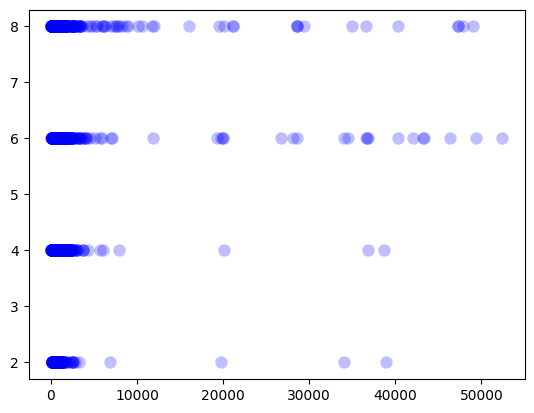

In [4]:
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
plt.scatter(datos_cluster['distancia'], datos_cluster['huespedes'], c='b', **plot_kwds)
frame = plt.gca()

In [5]:
def plot_clusters(data, algorithm, args, kwds,attributes=['distancia','huespedes']):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data[attributes[0]], data[attributes[1]], c=colors, **plot_kwds)
    frame = plt.gca()
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

## K-MEANS

In [6]:
# Ejecutar K-Means
k_means = KMeans(init='k-means++', n_clusters=6, n_init=5, random_state=123456)
inicio = time.time()
kmeans_labels = k_means.fit_predict(X_normal)
fin = time.time()

# Calcular métricas
metric_CH = metrics.calinski_harabasz_score(X_normal, kmeans_labels)
metric_SC = metrics.silhouette_score(X_normal, kmeans_labels, metric='euclidean')

print(f"k-means Calinski-Harabasz Index: {metric_CH:.3f}, Silhouette: {metric_SC:.3f}, tiempo ejecución: {fin-inicio}")


k-means Calinski-Harabasz Index: 8932.388, Silhouette: 0.739, tiempo ejecución: 0.11998486518859863


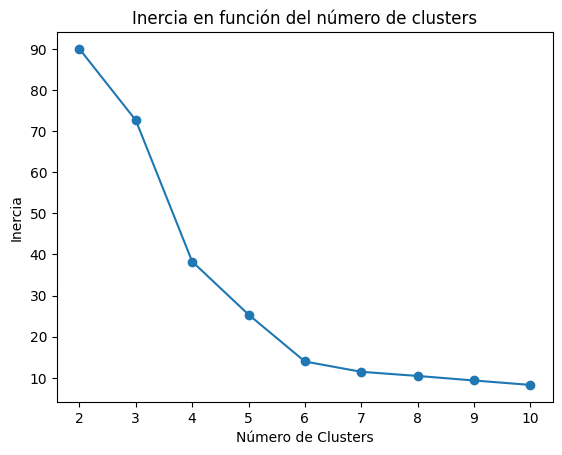

In [7]:
inercia = []
for k in range(2, 11):  # Probar con 2 a 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=123456)
    kmeans.fit(X_normal)
    inercia.append(kmeans.inertia_)

# Graficar la inercia para diferentes valores de k
plt.plot(range(2, 11), inercia, marker='o')
plt.title("Inercia en función del número de clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Inercia")
plt.show()

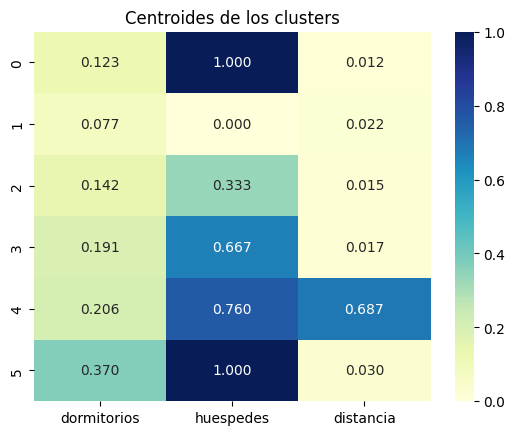

<ipython-input-8-4e0fb742f1ea>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_cluster['cluster'] = clusters['cluster']


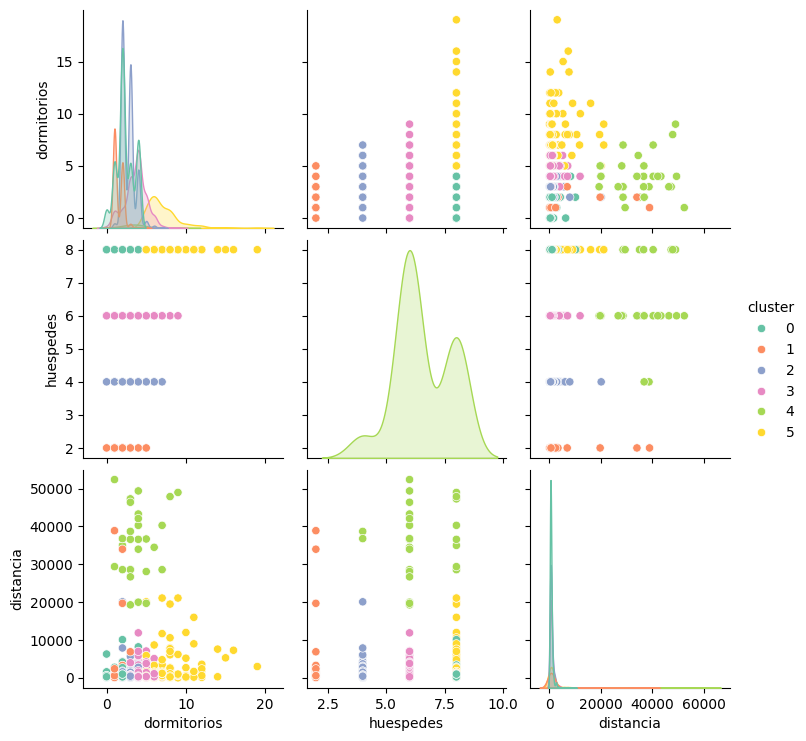

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap de centroides
centers = pd.DataFrame(k_means.cluster_centers_, columns=X_normal.columns)
sns.heatmap(centers, cmap="YlGnBu", annot=True, fmt='.3f')
plt.title("Centroides de los clusters")
plt.show()

# Scatter matrix
clusters = pd.DataFrame(kmeans_labels, index=X_normal.index, columns=['cluster'])
datos_cluster['cluster'] = clusters['cluster']
sns.pairplot(datos_cluster, vars=['dormitorios','huespedes','distancia'], hue="cluster", palette="Set2")
plt.show()


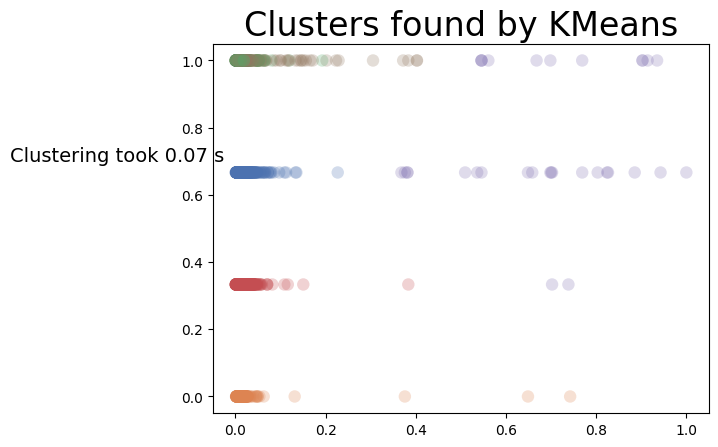

In [10]:
plot_clusters(X_normal, KMeans, (), {'n_clusters':6})


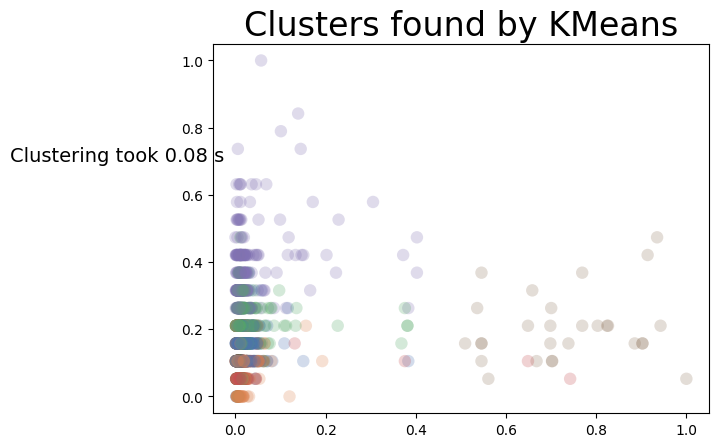

In [11]:
plot_clusters(X_normal, KMeans, (), {'n_clusters':6},attributes=['distancia','dormitorios'])


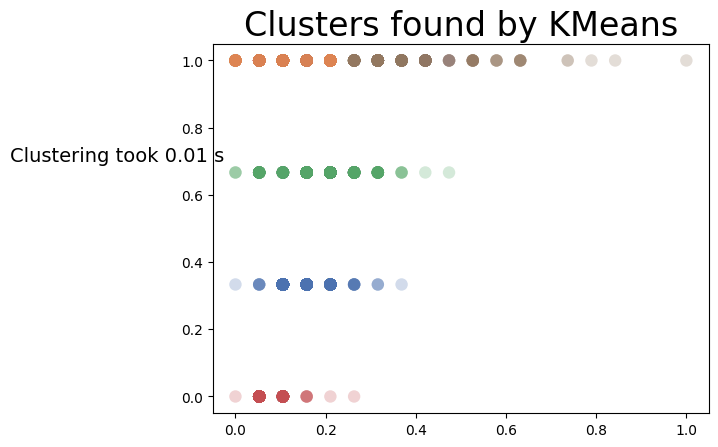

In [12]:
plot_clusters(X_normal, KMeans, (), {'n_clusters':6},attributes=['dormitorios','huespedes'])

## DBSCAN

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Ejecutar DBSCAN
dbscan = DBSCAN(eps=0.05, min_samples=6)
inicio = time.time()
dbscan_labels = dbscan.fit_predict(X_normal)
fin = time.time()

# Evaluar la calidad (usualmente no usamos métricas de inercia con DBSCAN)
calinski_harabasz_dbscan = metrics.calinski_harabasz_score(X_normal, dbscan_labels)
silhouette_dbscan = metrics.silhouette_score(X_normal, dbscan_labels)
print(f"dbscan Calinski-Harabasz Index: {calinski_harabasz_dbscan:.3f}, k-means Silhouette: {silhouette_dbscan:.3f}, tiempo ejecución: {fin-inicio}")


dbscan Calinski-Harabasz Index: 1049.945, k-means Silhouette: 0.749, tiempo ejecución: 0.08512377738952637


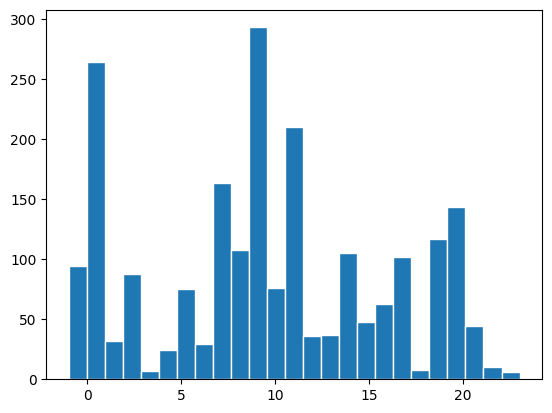

In [14]:
#calcular el numero de elementos en cada cluster y mostrarlo en un histograma
unique, counts = np.unique(dbscan_labels, return_counts=True)
fig, ax = plt.subplots()
ax.hist(dbscan_labels,edgecolor = "white", bins=len(unique))
plt.show()

<ipython-input-15-1c41bcf966f6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_cluster['cluster'] = clusters['cluster']


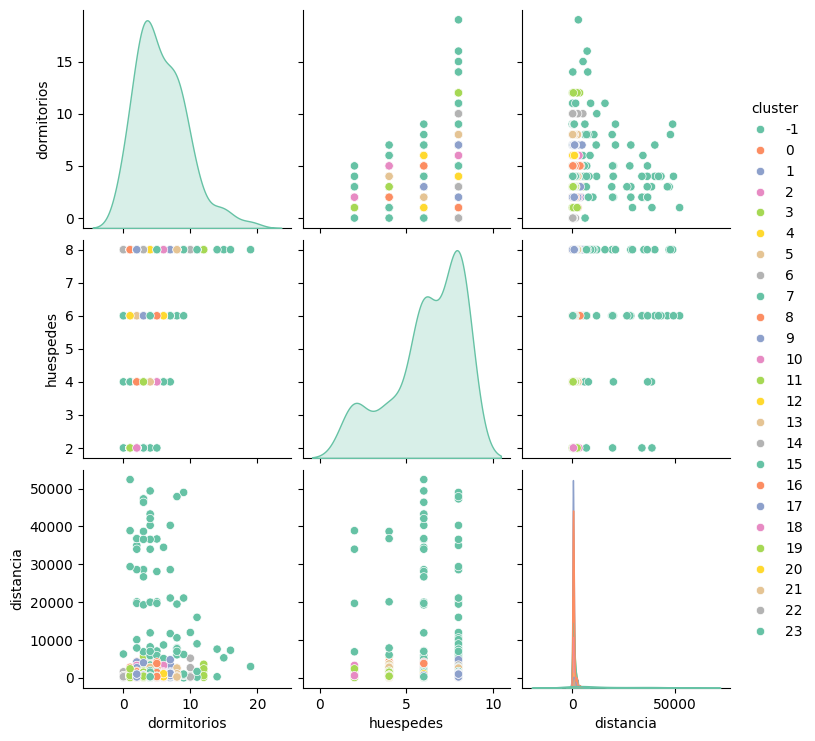

In [15]:
# Scatter matrix
clusters = pd.DataFrame(dbscan_labels, index=X_normal.index, columns=['cluster'])
datos_cluster['cluster'] = clusters['cluster']
sns.pairplot(datos_cluster, vars=['dormitorios','huespedes','distancia'], hue="cluster", palette="Set2")
plt.show()

In [16]:
# Probar con diferentes valores de eps
eps_values = [0.01, 0.02, 0.03, 0.04,0.05,0.06,0.07]
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=10)
    dbscan_labels = dbscan.fit_predict(X_normal)
    silhouette = metrics.silhouette_score(X_normal, dbscan_labels)
    print(f"DBSCAN - eps={eps} Silhouette: {silhouette}")

DBSCAN - eps=0.01 Silhouette: 0.7113127831945119
DBSCAN - eps=0.02 Silhouette: 0.7242165366517701
DBSCAN - eps=0.03 Silhouette: 0.7271559671244867
DBSCAN - eps=0.04 Silhouette: 0.7281686648447941
DBSCAN - eps=0.05 Silhouette: 0.7330467761153561
DBSCAN - eps=0.06 Silhouette: 0.7206748380650837
DBSCAN - eps=0.07 Silhouette: 0.7221884148527346


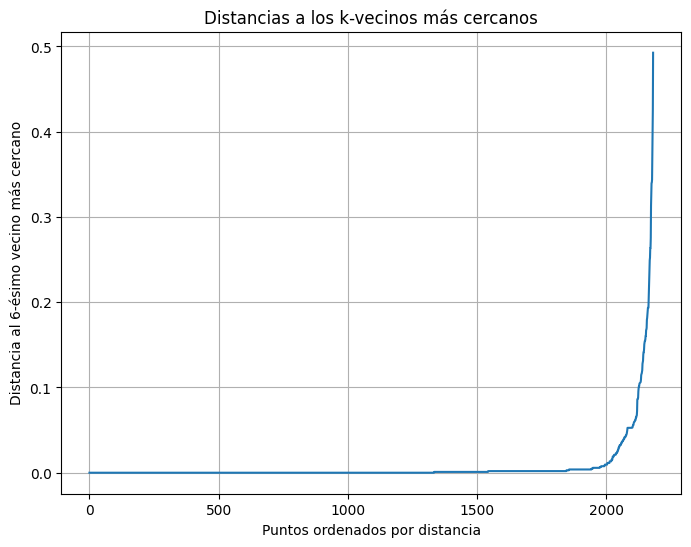

In [17]:
# Número de vecinos más cercanos (puedes probar con diferentes valores, como 4 o 5)
k = 6

# Crear el modelo de vecinos más cercanos
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_normal)

# Calcular las distancias a los k-vecinos más cercanos
distances, indices = neighbors_fit.kneighbors(X_normal)

# Obtener la distancia al k-vecino más cercano (usamos la última columna que es la distancia al k-ésimo vecino)
distances = np.sort(distances[:, k-1], axis=0)

# Graficar las distancias
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title('Distancias a los k-vecinos más cercanos')
plt.xlabel('Puntos ordenados por distancia')
plt.ylabel(f'Distancia al {k}-ésimo vecino más cercano')
plt.grid(True)
plt.show()


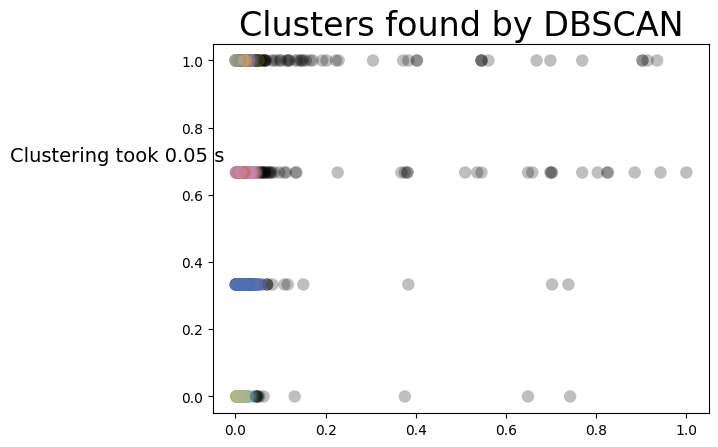

In [18]:
plot_clusters(X_normal, DBSCAN, (), {'eps':0.01,'min_samples':6})

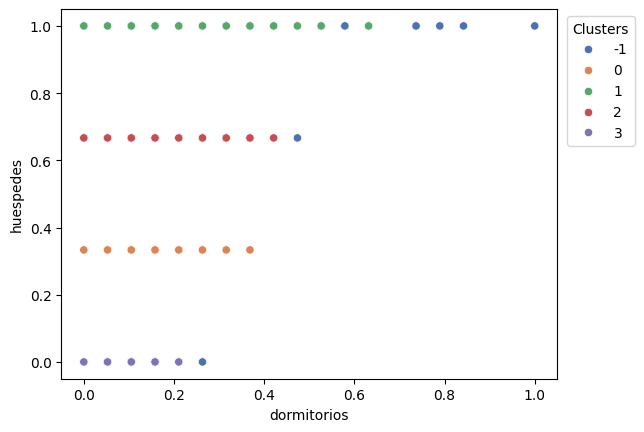

In [19]:
p = sns.scatterplot(data = X_normal, x = "dormitorios", y = "huespedes", hue = dbscan.labels_, legend = "full", palette = "deep")
sns.move_legend(p, "upper right", bbox_to_anchor = (1.17, 1.), title = 'Clusters')
plt.show()

## AGGLOMERATIVE CLUSTERING





In [20]:
# Ejecutar Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=2)
inicio = time.time()
agglo_labels = agglo.fit_predict(X_normal)
fin = time.time()

# Evaluar la calidad
calinski_harabasz_agglo = metrics.calinski_harabasz_score(X_normal, dbscan_labels)
silhouette_agglo = metrics.silhouette_score(X_normal, agglo_labels)
print(f"Agglomerative Clustering Calinski-Harabasz Index: {calinski_harabasz_agglo:.3f}, k-means Silhouette: {silhouette_agglo:.3f}, tiempo ejecución: {fin-inicio}")


Agglomerative Clustering Calinski-Harabasz Index: 4767.145, k-means Silhouette: 0.641, tiempo ejecución: 0.1668708324432373


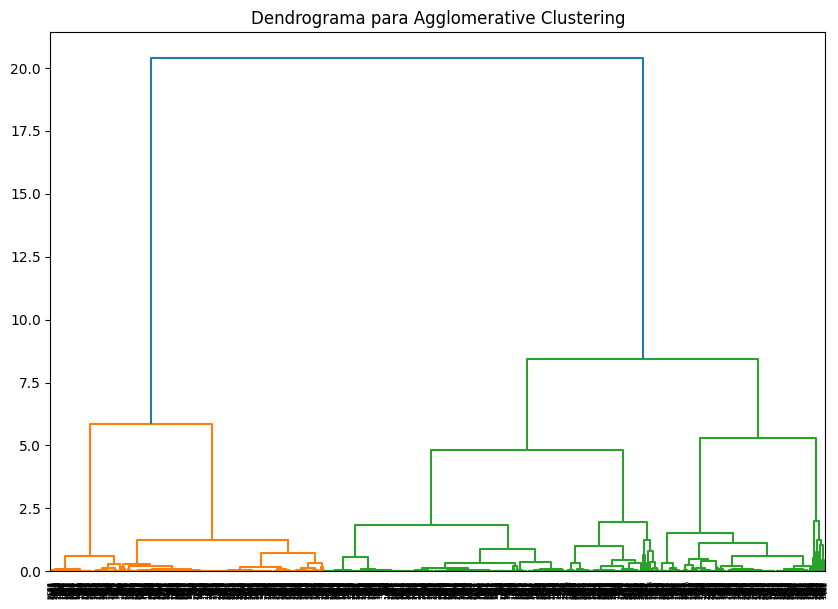

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Generar el linkage para Agglomerative Clustering
Z = linkage(X_normal, 'ward')

# Visualizar el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title("Dendrograma para Agglomerative Clustering")
plt.show()

<ipython-input-22-40f53691edc9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_cluster['cluster'] = clusters['cluster']


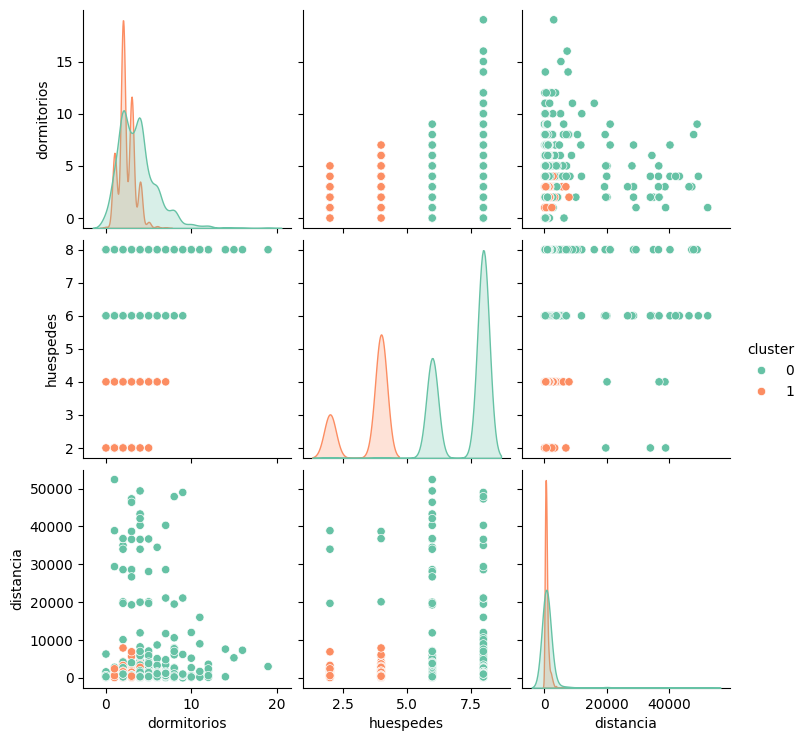

In [22]:
# Scatter matrix
clusters = pd.DataFrame(agglo_labels, index=X_normal.index, columns=['cluster'])
datos_cluster['cluster'] = clusters['cluster']
sns.pairplot(datos_cluster, vars=['dormitorios','huespedes','distancia'], hue="cluster", palette="Set2")
plt.show()

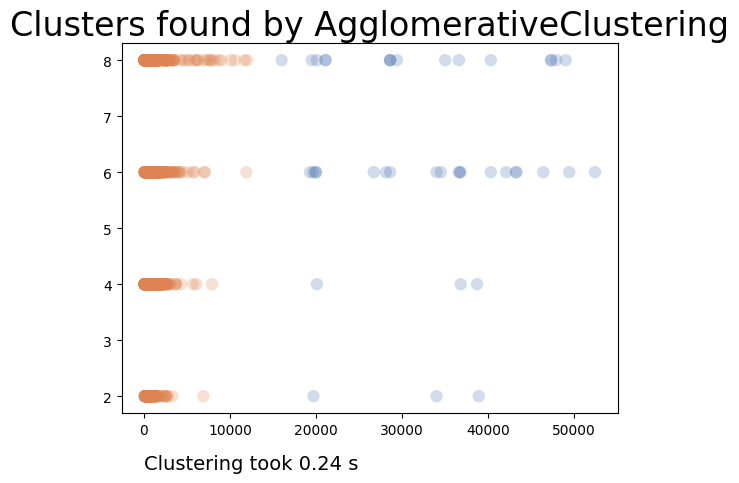

In [23]:
plot_clusters(datos_cluster, AgglomerativeClustering, (), {'n_clusters':2})

## GMM

In [24]:
# Ejecutar GMM
gmm = GaussianMixture(n_components=5, random_state=123456)
inicio = time.time()
gmm_labels = gmm.fit_predict(X_normal)
fin = time.time()

# Evaluar la calidad
calinski_harabasz_gmm = metrics.calinski_harabasz_score(X_normal, gmm_labels)
silhouette_gmm = metrics.silhouette_score(X_normal, gmm_labels)
print(f"GMM Calinski-Harabasz Index: {calinski_harabasz_gmm:.3f}, k-means Silhouette: {silhouette_gmm:.3f}, tiempo ejecución: {fin-inicio}")


GMM Calinski-Harabasz Index: 4116.561, k-means Silhouette: 0.708, tiempo ejecución: 0.12178468704223633


In [25]:
# encontrar numero optimo de clusters por puntuacionde silueta
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

n_clusters=np.arange(2, 20)
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2).fit(X_normal)
        labels=gmm.predict(X_normal)
        sil=metrics.silhouette_score(X_normal, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

Text(0, 0.5, 'Score')

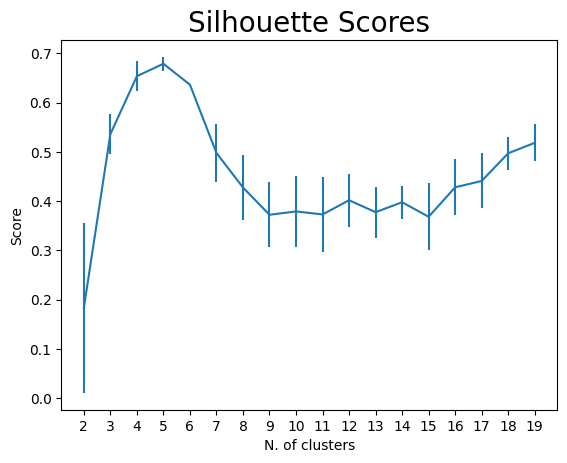

In [26]:
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

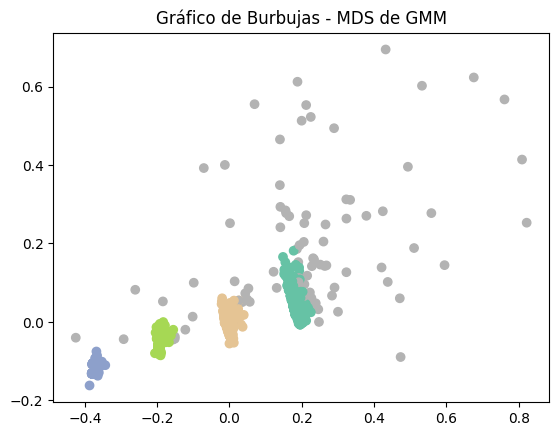

In [27]:
from sklearn.manifold import MDS

# Aplicar MDS para reducción de dimensionalidad
mds = MDS(n_components=5)
X_mds = mds.fit_transform(X_normal)

# Gráfico de dispersión de MDS
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=gmm_labels, cmap="Set2")
plt.title("Gráfico de Burbujas - MDS de GMM")
plt.show()


<ipython-input-28-53fa4f5af621>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_cluster['cluster'] = clusters['cluster']


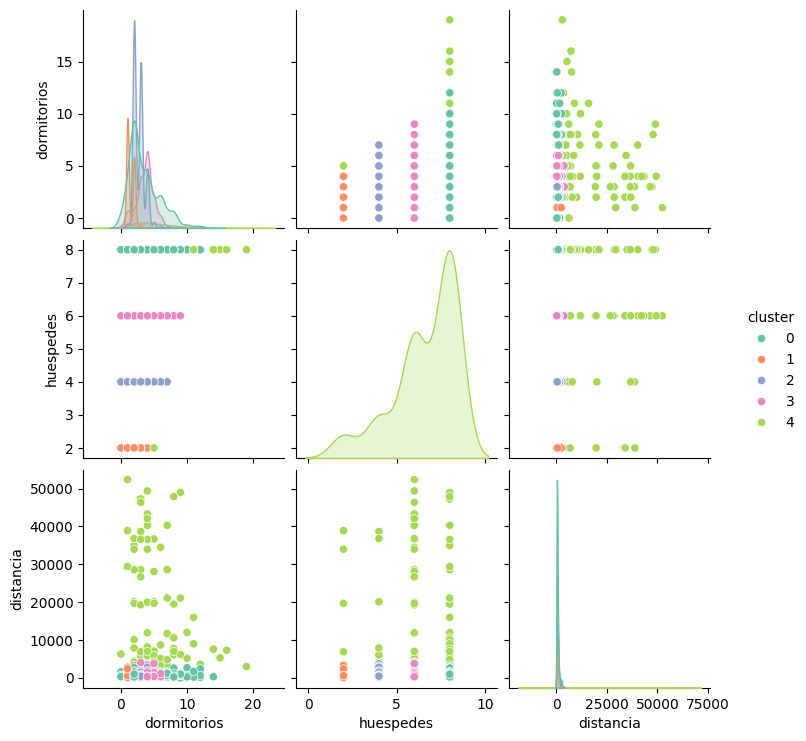

In [28]:
# Scatter matrix
clusters = pd.DataFrame(gmm_labels, index=X_normal.index, columns=['cluster'])
datos_cluster['cluster'] = clusters['cluster']
sns.pairplot(datos_cluster, vars=['dormitorios','huespedes','distancia'], hue="cluster", palette="Set2")
plt.show()

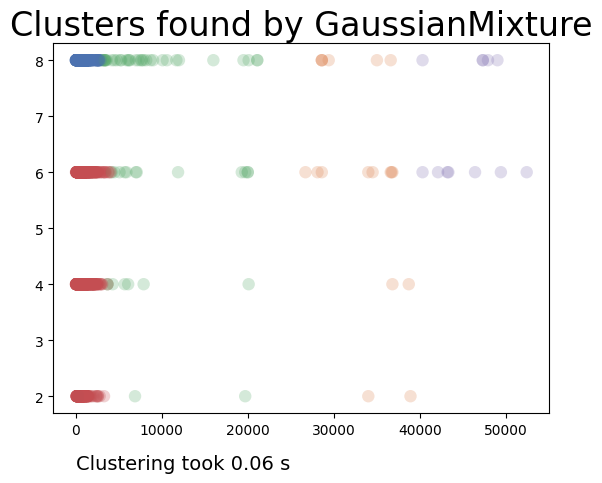

In [29]:
plot_clusters(datos_cluster, GaussianMixture, (), {'n_components':5})

<Axes: xlabel='huespedes', ylabel='dormitorios'>

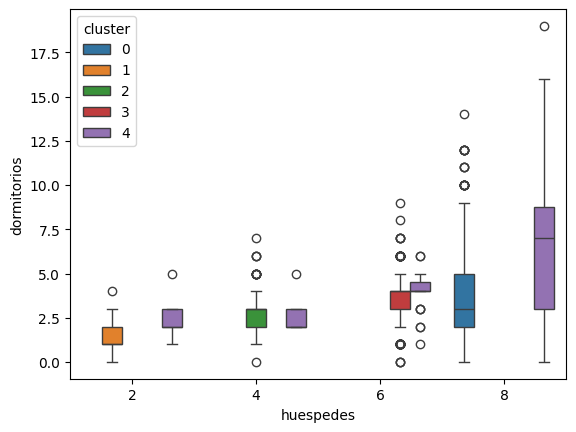

In [30]:
sns.boxplot(x = datos_cluster['huespedes'],
            y = datos_cluster['dormitorios'],
            hue = datos_cluster['cluster'],
            palette = 'tab10')

## MEANSHIFT

In [31]:
from sklearn.cluster import MeanShift

# Ejecutar MeanShift
meanshift = MeanShift()
inicio = time.time()
meanshift_labels = meanshift.fit_predict(X_normal)
fin = time.time()

# Evaluar la calidad
calinski_harabasz_meanshift = metrics.calinski_harabasz_score(X_normal, meanshift_labels)
silhouette_meanshift = metrics.silhouette_score(X_normal, meanshift_labels)
print(f"MeanShift Calinski-Harabasz Index: {calinski_harabasz_meanshift:.3f}, k-means Silhouette: {silhouette_meanshift:.3f}, tiempo ejecución: {fin-inicio}")

MeanShift Calinski-Harabasz Index: 3402.392, k-means Silhouette: 0.727, tiempo ejecución: 5.197042942047119


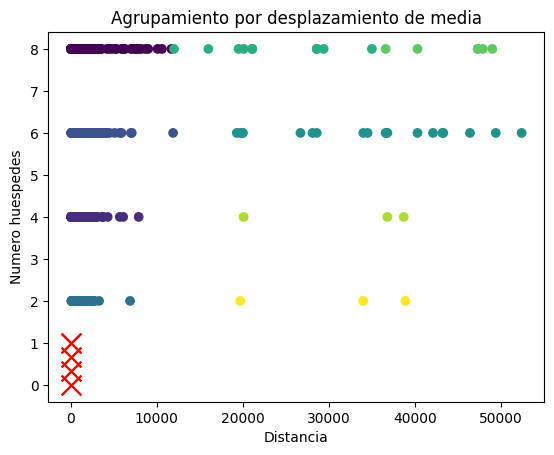

In [32]:
ms = MeanShift()
# Ajuste del modelo a los datos
ms.fit(X_normal)
# Extracción de las etiquetas y los centros de los clústeres
labels = ms.labels_
centers = ms.cluster_centers_
# Visualización de los clústeres
plt.scatter(datos_cluster['distancia'], datos_cluster['huespedes'], c=labels)
plt.scatter(centers[:, 0 ], centers[:, 1 ], marker= 'x' , color= 'red' , s= 200 )
plt.xlabel( 'Distancia' )
plt.ylabel( 'Numero huespedes' )
plt.title( 'Agrupamiento por desplazamiento de media' )
plt.show()

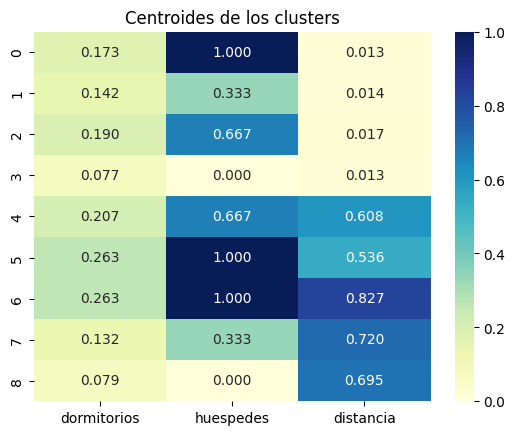

In [33]:
# Heatmap de centroides
centers = pd.DataFrame(meanshift.cluster_centers_, columns=X_normal.columns)
sns.heatmap(centers, cmap="YlGnBu", annot=True, fmt='.3f')
plt.title("Centroides de los clusters")
plt.show()

<Axes: xlabel='huespedes', ylabel='dormitorios'>

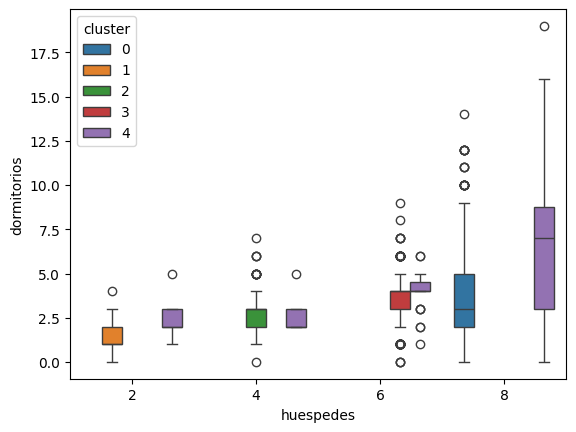

In [34]:
sns.boxplot(x = datos_cluster['huespedes'],
            y = datos_cluster['dormitorios'],
            hue = datos_cluster['cluster'],
            palette = 'tab10')

<ipython-input-35-961d944b1bdb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_cluster['cluster'] = clusters['cluster']


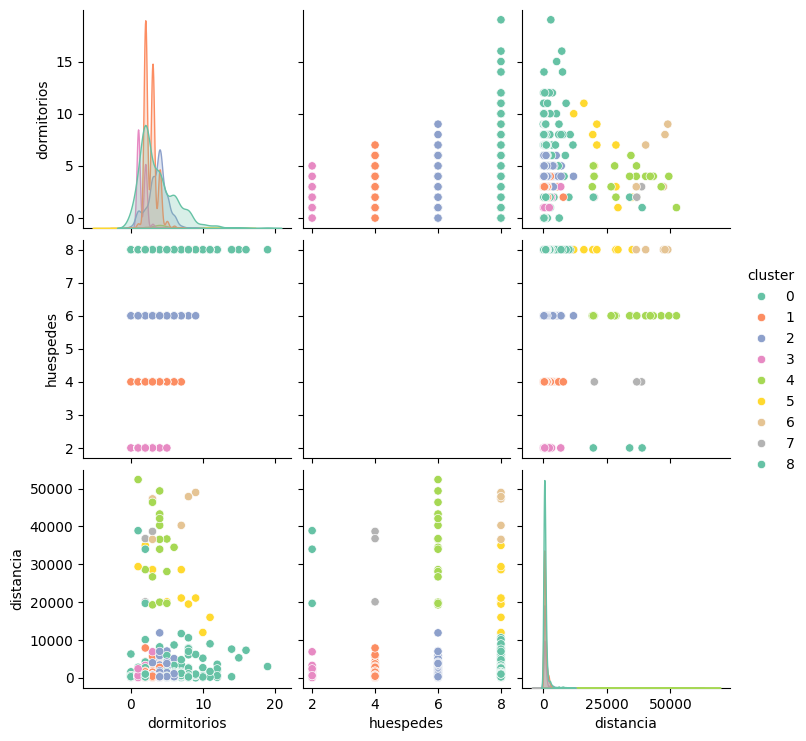

In [35]:
# Scatter matrix
clusters = pd.DataFrame(meanshift_labels, index=X_normal.index, columns=['cluster'])
datos_cluster['cluster'] = clusters['cluster']
sns.pairplot(datos_cluster, vars=['dormitorios','huespedes','distancia'], hue="cluster", palette="Set2")
plt.show()

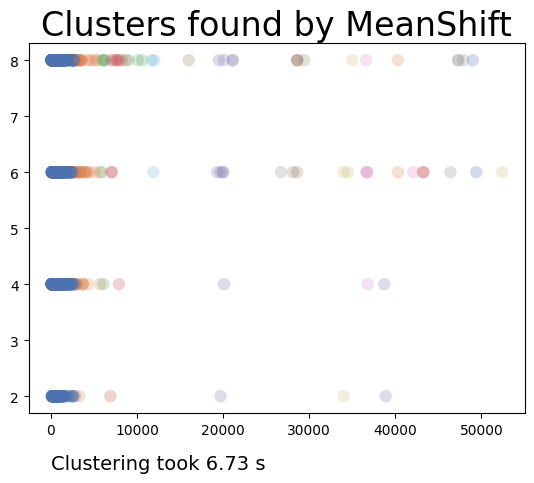

In [36]:
plot_clusters(datos_cluster, MeanShift, (), {})

# Caso de estudio 3


In [37]:
apartamentos_albaicin = datos[datos.Location.str.contains('Albaicín') & datos.Type.str.contains('apartamento')]
apartamentos_centro = datos[datos.Location.str.contains('Centro de Granada') & datos.Type.str.contains('apartamento')]


# Selección de columnas y renombrado
columnas_renombradas = {"Price avg": "precio", "Rating": "valoracion",
                        "Ranking position avg": "ranking", "Total Beds": "dormitorios",
                        "Type":"tipo", "Quality":"estrellas","Guests":"huespedes",
                        "Distance":"distancia", "Number of views":"visitas",
                        "Review":"reseñas","Surface Area (m2)":'area',"Special":'categoria'}

datos3_cluster_alb = apartamentos_albaicin.rename(columns=columnas_renombradas)
datos3_cluster_cen = apartamentos_centro.rename(columns=columnas_renombradas)

# Combinar conjuntos
# por ahora la que mas -> precio, estrellas (categoria)
usadas = ['estrellas','categoria','area', 'precio']
# category to number in Special
datos3_cluster_alb['categoria'] = datos3_cluster_alb['categoria'].astype('category')
datos3_cluster_alb['categoria'] = datos3_cluster_alb['categoria'].cat.codes
datos3_cluster_alb = datos3_cluster_alb[usadas]

datos3_cluster_cen['categoria'] = datos3_cluster_cen['categoria'].astype('category')
datos3_cluster_cen['categoria'] = datos3_cluster_cen['categoria'].cat.codes
datos3_cluster_cen = datos3_cluster_cen[usadas]

# Normalización
X2_normal_alb = datos3_cluster_alb.apply(norm_to_zero_one)
X2_normal_cen = datos3_cluster_cen.apply(norm_to_zero_one)

print(f"Alojamientos apartamentos en el Albaicin: {len(X2_normal_alb)}")
print(f"Alojamientos apartamentos en el Centro: {len(X2_normal_cen)}")

Alojamientos apartamentos en el Albaicin: 374
Alojamientos apartamentos en el Centro: 904


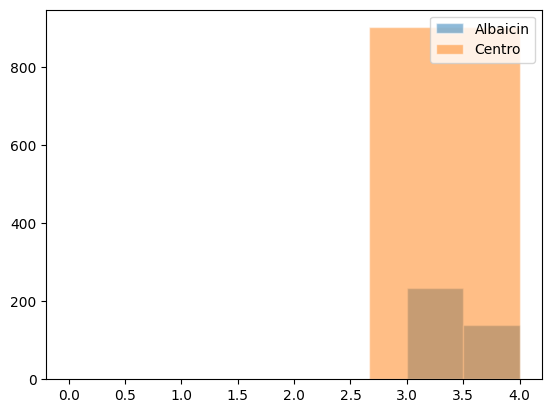

In [38]:
unique1, counts1 = np.unique(datos3_cluster_alb['estrellas'], return_counts=True)
unique2, counts2 = np.unique(datos3_cluster_cen['estrellas'], return_counts=True)
plt.hist(datos3_cluster_alb['estrellas'],alpha=0.5,edgecolor = "white", bins=len(unique1), label='Albaicin')
plt.hist(datos3_cluster_cen['estrellas'],alpha=0.5,edgecolor = "white", bins=len(unique2), label='Centro')
plt.legend(loc='upper right')
plt.show()

In [39]:
print("Calidad (en estrellas):",unique1,"Cantidad:", counts1)
print("Calidad (en estrellas):",unique2,"Cantidad:", counts2)

Calidad (en estrellas): [3 4] Cantidad: [234 140]
Calidad (en estrellas): [0 3 4] Cantidad: [  1 505 398]


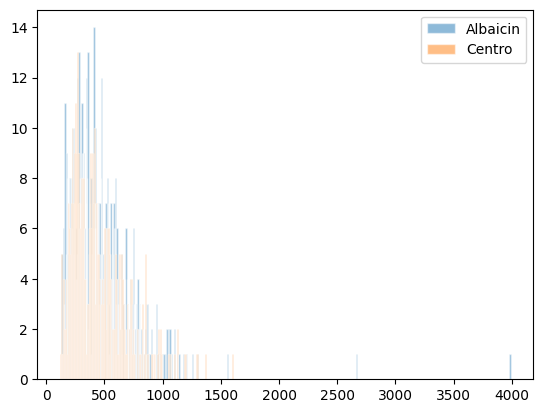

In [40]:
unique1, counts = np.unique(datos3_cluster_alb['precio'], return_counts=True)
unique2, counts = np.unique(datos3_cluster_cen['precio'], return_counts=True)
plt.hist(datos3_cluster_alb['precio'],alpha=0.5,edgecolor = "white", bins=len(unique1), label='Albaicin')
plt.hist(datos3_cluster_cen['precio'],alpha=0.5,edgecolor = "white", bins=len(unique2), label='Centro')
plt.legend(loc='upper right')
plt.show()

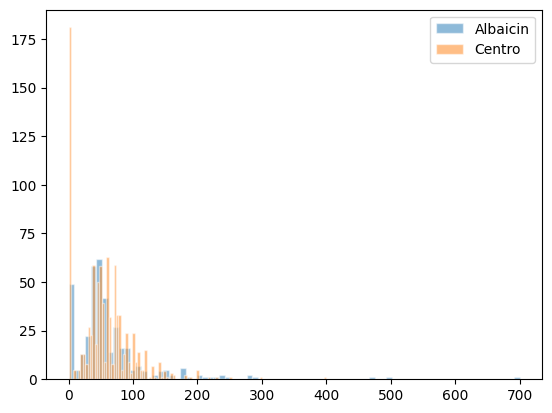

In [41]:
unique1, counts = np.unique(datos3_cluster_alb['area'], return_counts=True)
unique2, counts = np.unique(datos3_cluster_cen['area'], return_counts=True)
plt.hist(datos3_cluster_alb['area'],alpha=0.5,edgecolor = "white", bins=len(unique1), label='Albaicin')
plt.hist(datos3_cluster_cen['area'],alpha=0.5,edgecolor = "white", bins=len(unique2), label='Centro')
plt.legend(loc='upper right')
plt.show()

In [42]:
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
def plot_clusters(data, algorithm, args, kwds,attributes=['area','precio']):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    metric_CH = metrics.calinski_harabasz_score(data, labels)
    metric_SC = metrics.silhouette_score(data, labels, metric='euclidean')
    print(f"Calinski-Harabasz Index: {metric_CH:.3f}, Silhouette: {metric_SC:.3f}, tiempo ejecución: {end_time-start_time}")

    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data[attributes[0]], data[attributes[1]], c=colors, **plot_kwds)
    frame = plt.gca()
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

## K-MEANS

Calinski-Harabasz Index: 2407.825, Silhouette: 0.528, tiempo ejecución: 0.007548332214355469


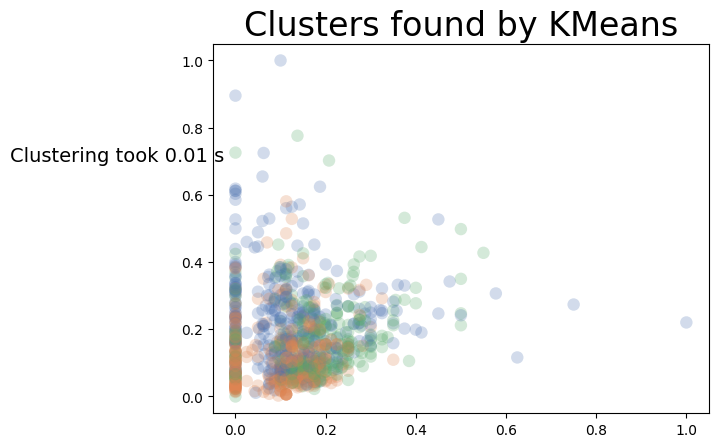

In [43]:
plot_clusters(X2_normal_cen, KMeans, (), {'n_clusters':3})

Calinski-Harabasz Index: 2098.331, Silhouette: 0.807, tiempo ejecución: 0.012238740921020508


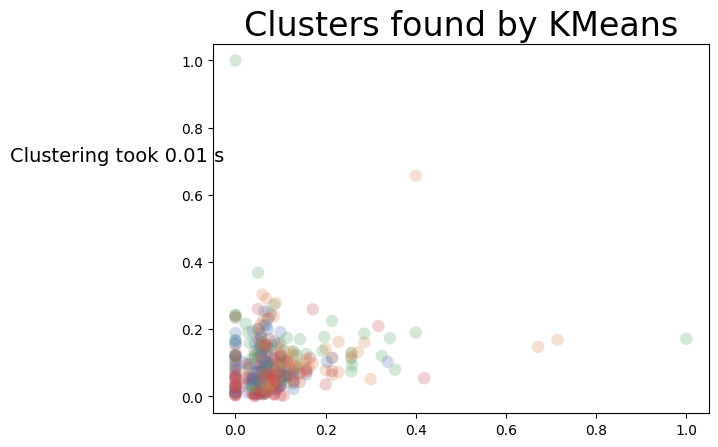

In [44]:
plot_clusters(X2_normal_alb, KMeans, (), {'n_clusters':4})

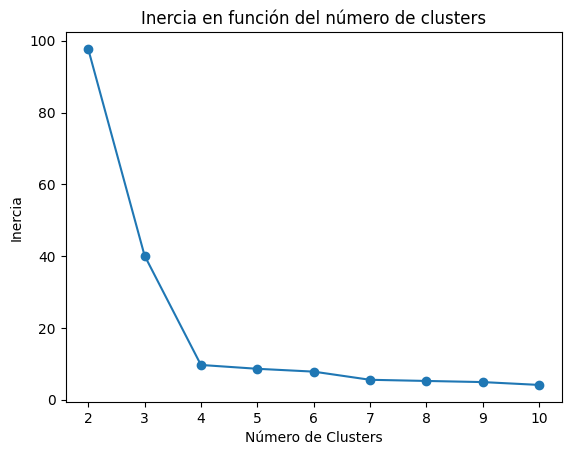

In [45]:
inercia = []
for k in range(2, 11):  # Probar con 2 a 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=123456)
    kmeans.fit(X2_normal_alb)
    inercia.append(kmeans.inertia_)

# Graficar la inercia para diferentes valores de k
plt.plot(range(2, 11), inercia, marker='o')
plt.title("Inercia en función del número de clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Inercia")
plt.show()

In [46]:
kmeans_alb = KMeans(init='k-means++', n_clusters=4, n_init=5, random_state=123456)
kmeans_labels_alb = kmeans_alb.fit_predict(X2_normal_alb)

kmeans_cen = KMeans(init='k-means++', n_clusters=3, n_init=5, random_state=123456)
kmeans_labels_cen = kmeans_cen.fit_predict(X2_normal_cen)

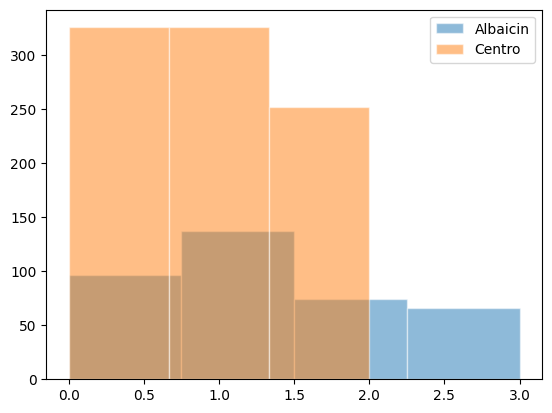

In [47]:
unique1, counts = np.unique(kmeans_labels_alb, return_counts=True)
unique2, counts = np.unique(kmeans_labels_cen, return_counts=True)
plt.hist(kmeans_labels_alb,alpha=0.5,edgecolor = "white", bins=len(unique1), label='Albaicin')
plt.hist(kmeans_labels_cen,alpha=0.5,edgecolor = "white", bins=len(unique2), label='Centro')
plt.legend(loc='upper right')
plt.show()

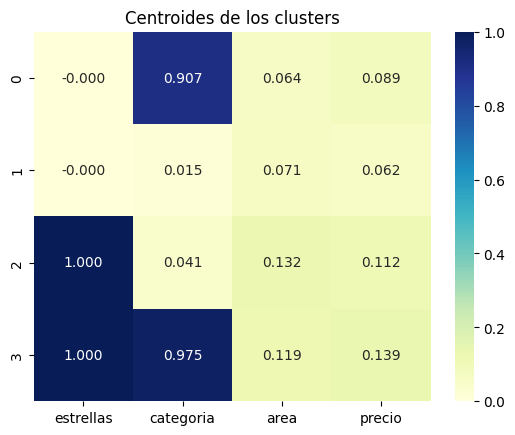

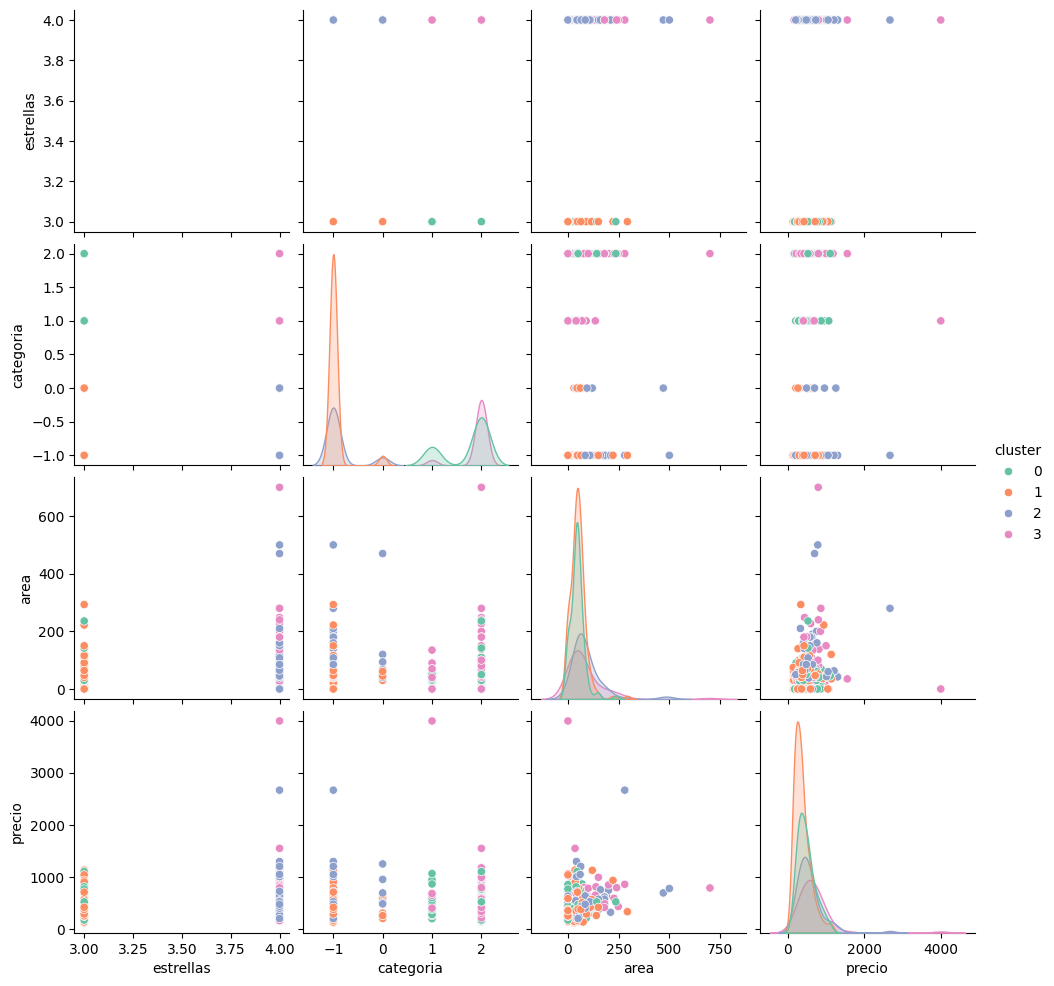

In [48]:
# Heatmap de centroides
centers = pd.DataFrame(kmeans_alb.cluster_centers_, columns=X2_normal_alb.columns)
sns.heatmap(centers, cmap="YlGnBu", annot=True, fmt='.3f')
plt.title("Centroides de los clusters")
plt.show()

# Scatter matrix
clusters = pd.DataFrame(kmeans_labels_alb, index=X2_normal_alb.index, columns=['cluster'])
datos3_cluster_alb['cluster'] = clusters['cluster']
sns.pairplot(datos3_cluster_alb, vars=['estrellas','categoria','area', 'precio'], hue="cluster", palette="Set2")
plt.show()

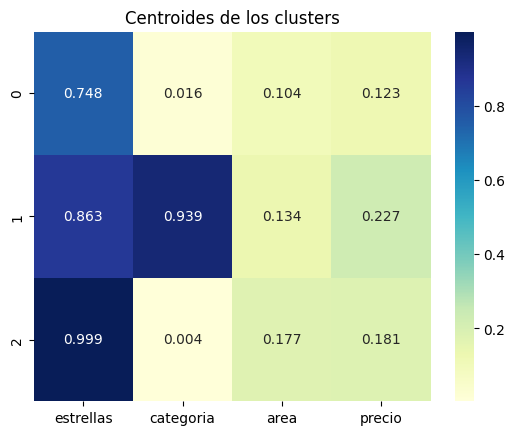

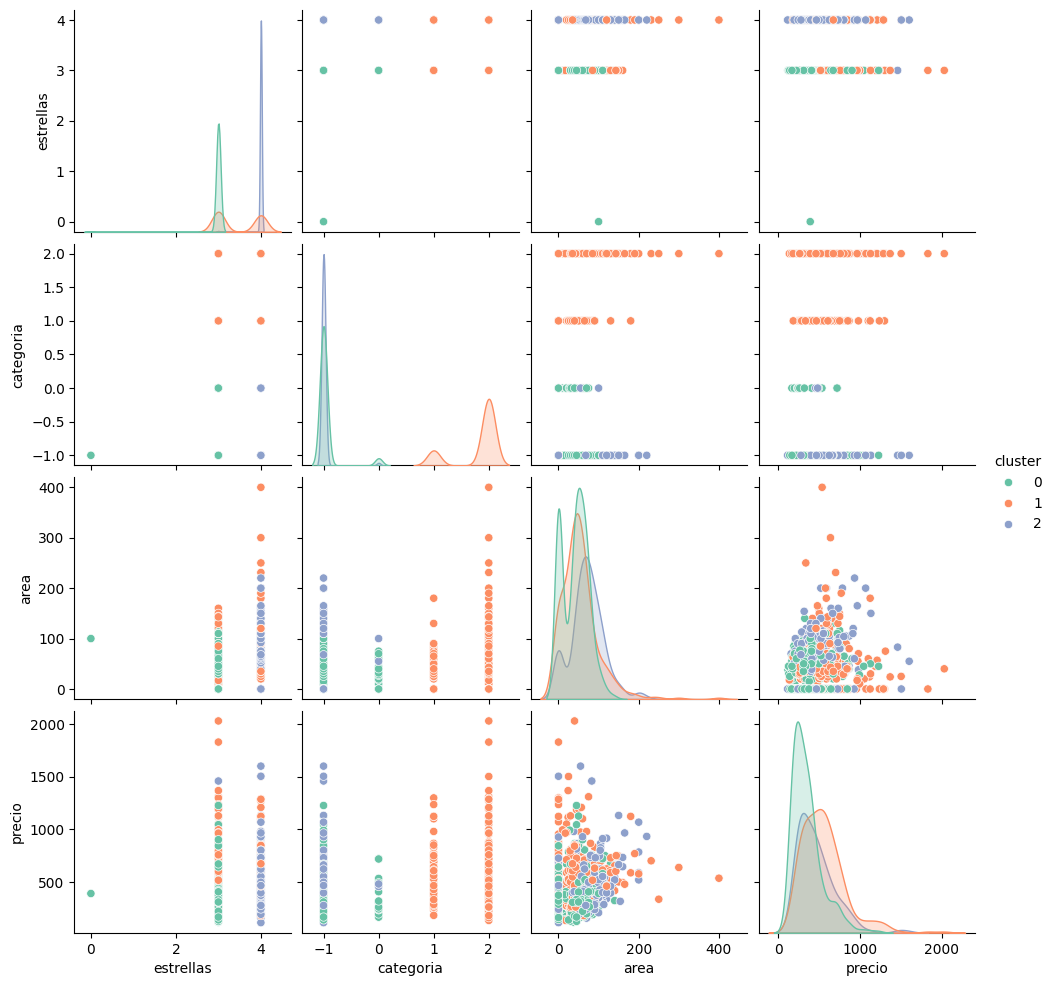

In [49]:
# Heatmap de centroides
centers = pd.DataFrame(kmeans_cen.cluster_centers_, columns=X2_normal_cen.columns)
sns.heatmap(centers, cmap="YlGnBu", annot=True, fmt='.3f')
plt.title("Centroides de los clusters")
plt.show()

# Scatter matrix
clusters = pd.DataFrame(kmeans_labels_cen, index=X2_normal_cen.index, columns=['cluster'])
datos3_cluster_cen['cluster'] = clusters['cluster']
sns.pairplot(datos3_cluster_cen, vars=['estrellas','categoria','area', 'precio'], hue="cluster", palette="Set2")
plt.show()

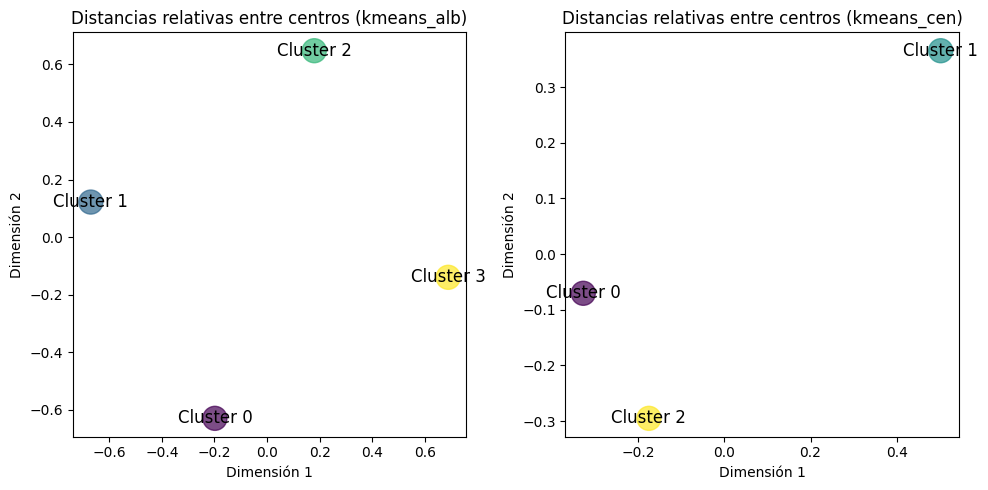

In [50]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import numpy as np

# Obtener los centros de los clústeres para cada modelo
centros_alb = kmeans_alb.cluster_centers_
centros_cen = kmeans_cen.cluster_centers_

# Calcular las distancias entre los centros de los clústeres
distancias_alb = np.linalg.norm(centros_alb[:, np.newaxis] - centros_alb, axis=2)
distancias_cen = np.linalg.norm(centros_cen[:, np.newaxis] - centros_cen, axis=2)

# Reducir la dimensionalidad a 2D usando MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=123456)

centros_alb_2d = mds.fit_transform(distancias_alb)
centros_cen_2d = mds.fit_transform(distancias_cen)

# Crear gráficos de burbujas para las distancias relativas
plt.figure(figsize=(10, 5))

# Gráfico para `kmeans_alb`
plt.subplot(1, 2, 1)
plt.scatter(centros_alb_2d[:, 0], centros_alb_2d[:, 1], s=300, alpha=0.7, c=range(len(centros_alb)), cmap="viridis")
for i, (x, y) in enumerate(centros_alb_2d):
    plt.text(x, y, f'Cluster {i}', fontsize=12, ha='center', va='center')
plt.title("Distancias relativas entre centros (kmeans_alb)")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")

# Gráfico para `kmeans_cen`
plt.subplot(1, 2, 2)
plt.scatter(centros_cen_2d[:, 0], centros_cen_2d[:, 1], s=300, alpha=0.7, c=range(len(centros_cen)), cmap="viridis")
for i, (x, y) in enumerate(centros_cen_2d):
    plt.text(x, y, f'Cluster {i}', fontsize=12, ha='center', va='center')
plt.title("Distancias relativas entre centros (kmeans_cen)")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")

plt.tight_layout()
plt.show()


## Agglomerative Clustering

Calinski-Harabasz Index: 1524.411, Silhouette: 0.777, tiempo ejecución: 0.009592294692993164


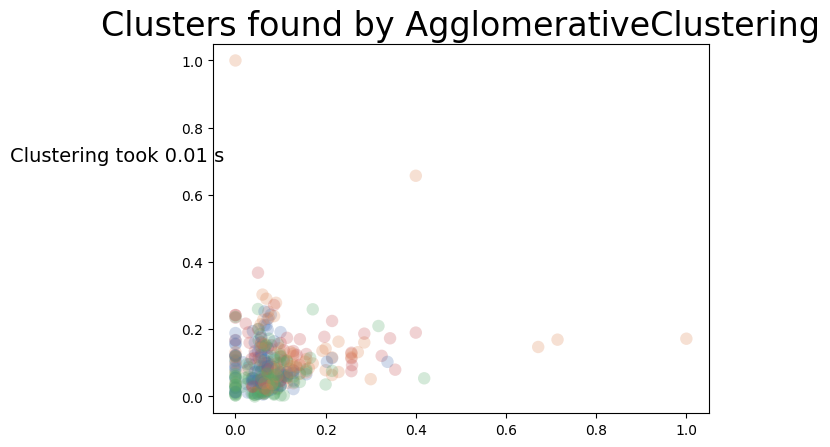

In [51]:
plot_clusters(X2_normal_alb, AgglomerativeClustering, (), {'n_clusters': 4, 'linkage': 'ward'})

Calinski-Harabasz Index: 3136.001, Silhouette: 0.681, tiempo ejecución: 0.027050495147705078


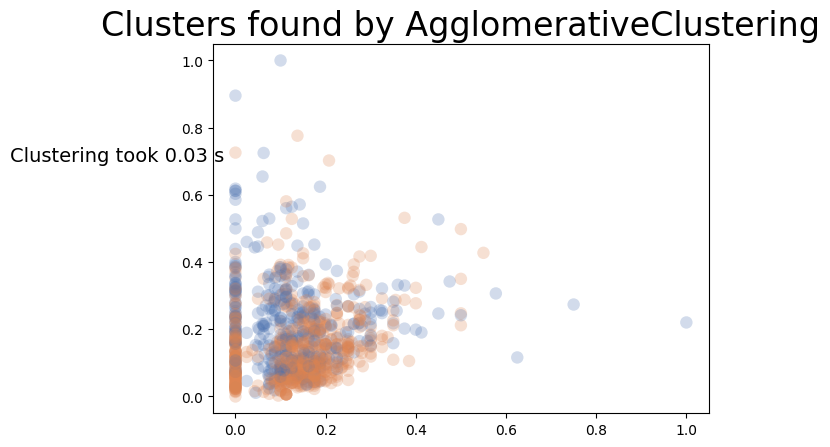

In [52]:
plot_clusters(X2_normal_cen, AgglomerativeClustering, (), {'n_clusters': 2, 'linkage': 'ward'})

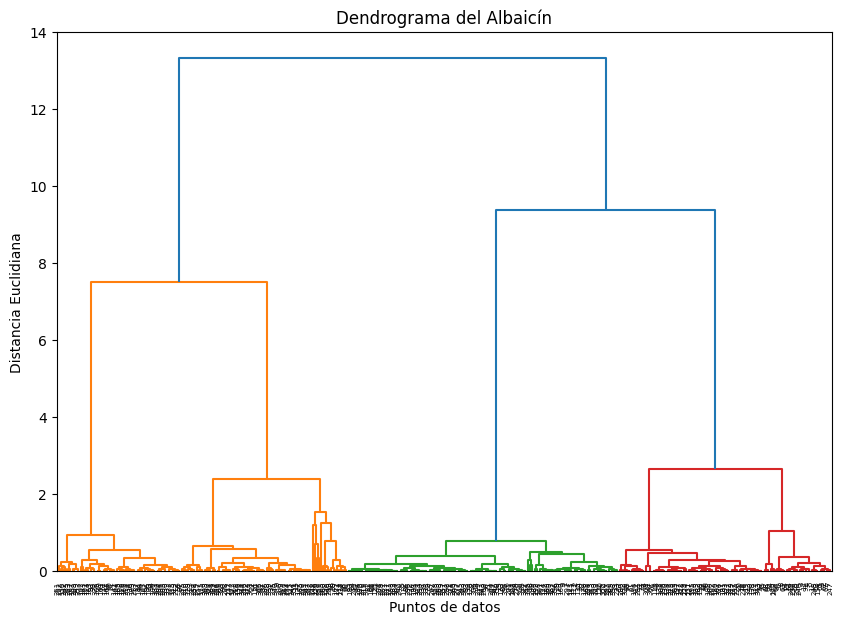

In [53]:
linkage_matrix = linkage(X2_normal_alb, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Dendrograma del Albaicín')
plt.xlabel('Puntos de datos')
plt.ylabel('Distancia Euclidiana')
plt.show()

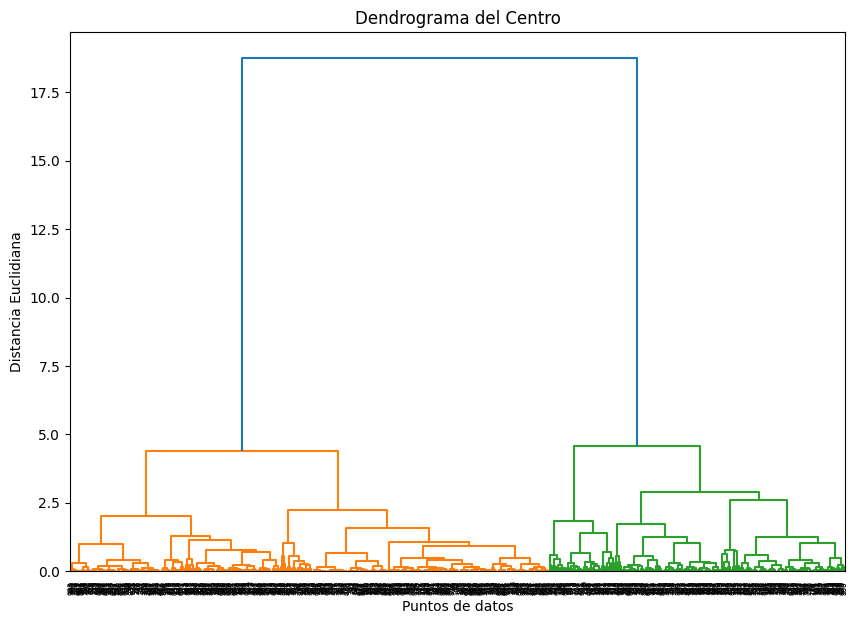

In [54]:
linkage_matrix = linkage(X2_normal_cen, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Dendrograma del Centro')
plt.xlabel('Puntos de datos')
plt.ylabel('Distancia Euclidiana')
plt.show()

In [55]:
agglomerative_alb = AgglomerativeClustering(n_clusters=4, linkage='ward')
agglomerative_labels_alb = agglomerative_alb.fit_predict(X2_normal_alb)

agglomerative_cen = AgglomerativeClustering(n_clusters=2, linkage='ward')
agglomerative_labels_cen = agglomerative_cen.fit_predict(X2_normal_cen)

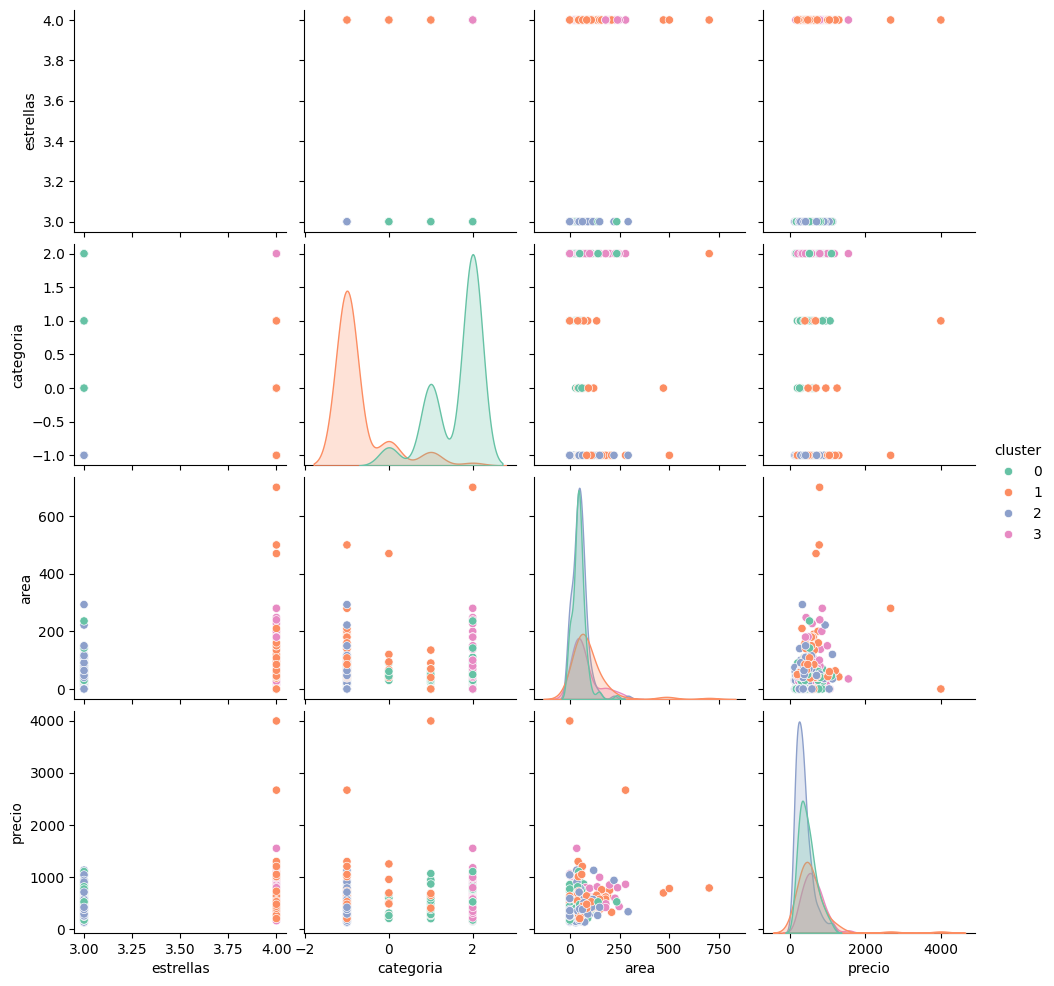

In [56]:
# Scatter matrix
clusters = pd.DataFrame(agglomerative_labels_alb, index=X2_normal_alb.index, columns=['cluster'])
datos3_cluster_alb['cluster'] = clusters['cluster']
sns.pairplot(datos3_cluster_alb, vars=['estrellas','categoria','area', 'precio'], hue="cluster", palette="Set2")
plt.show()

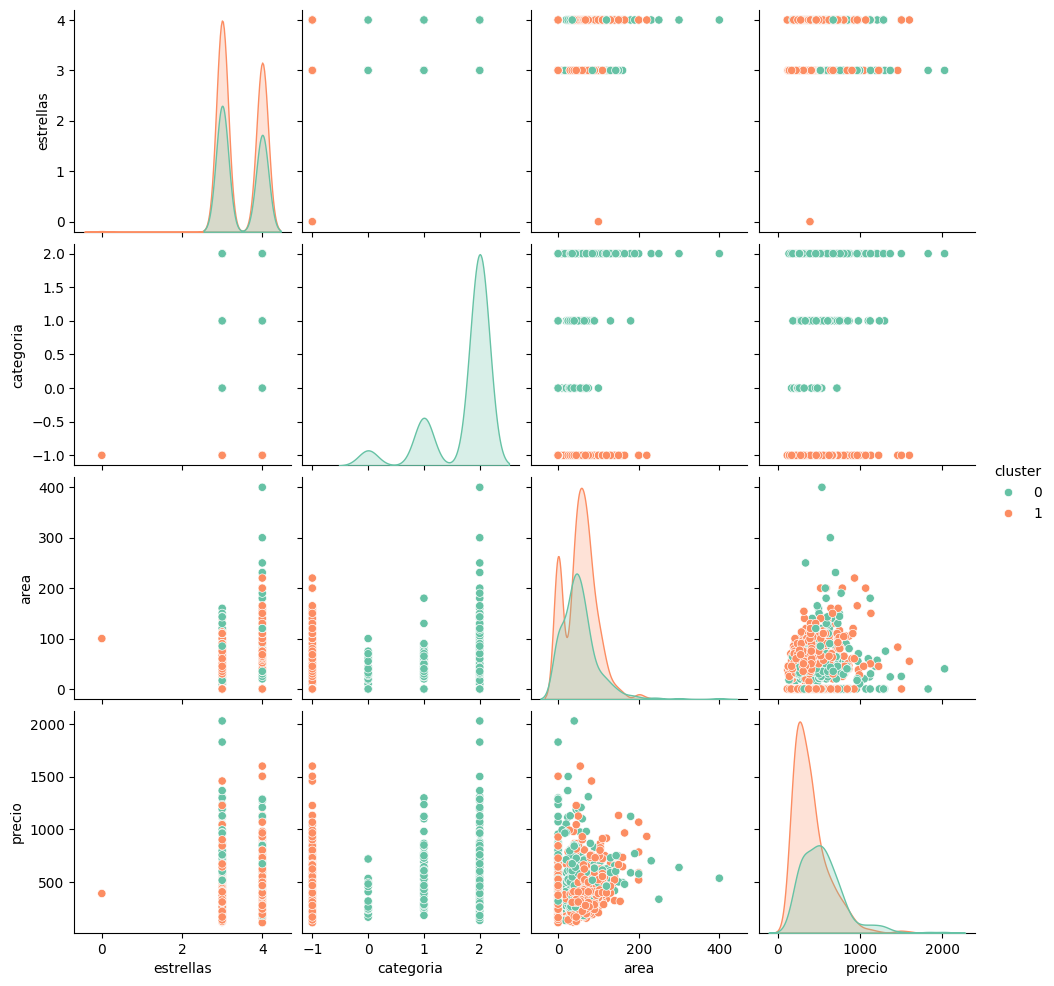

In [57]:
# Scatter matrix
clusters = pd.DataFrame(agglomerative_labels_cen, index=X2_normal_cen.index, columns=['cluster'])
datos3_cluster_cen['cluster'] = clusters['cluster']
sns.pairplot(datos3_cluster_cen, vars=['estrellas','categoria','area', 'precio'], hue="cluster", palette="Set2")
plt.show()

## DBSCAN


Calinski-Harabasz Index: 945.202, Silhouette: 0.728, tiempo ejecución: 0.011799812316894531


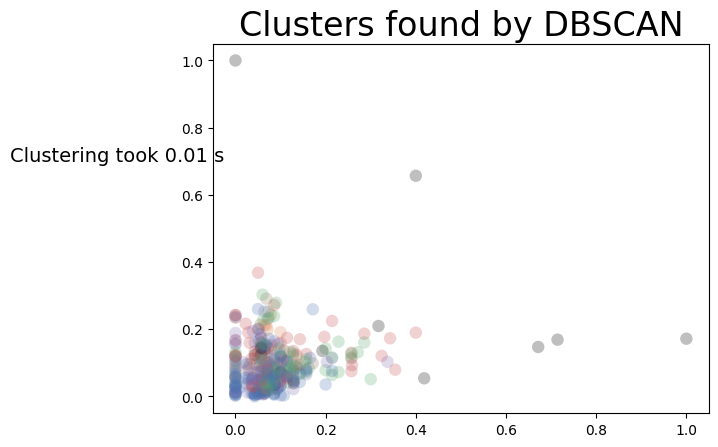

In [58]:
plot_clusters(X2_normal_alb, DBSCAN, (), {'eps':0.15,'min_samples':8})

Calinski-Harabasz Index: 1062.286, Silhouette: 0.462, tiempo ejecución: 0.018277883529663086


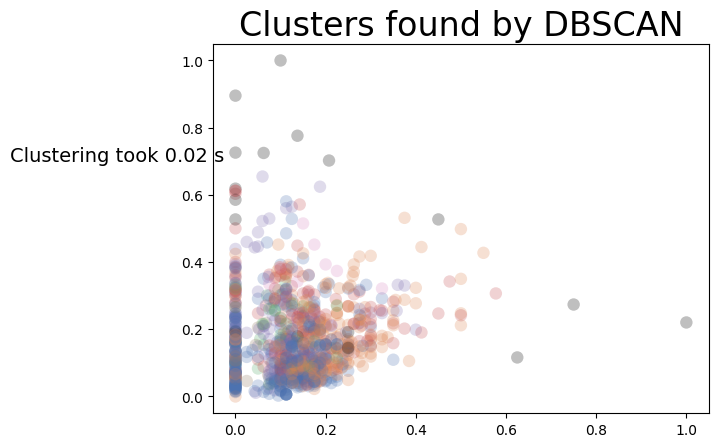

In [59]:
plot_clusters(X2_normal_cen, DBSCAN, (), {'eps':0.15,'min_samples':8})

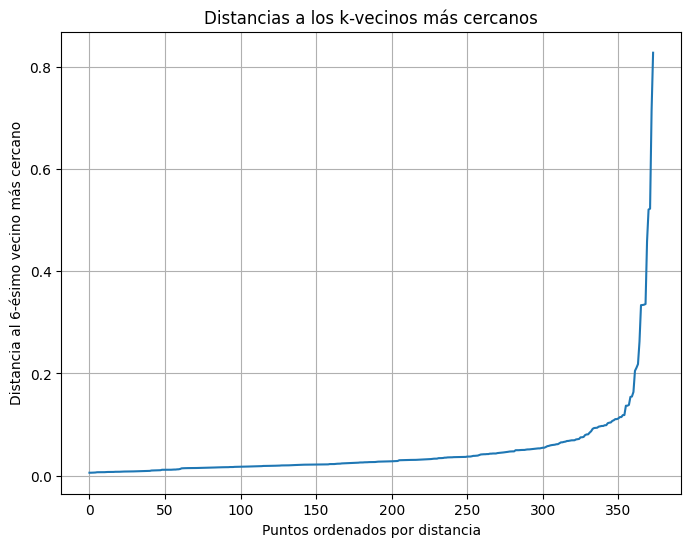

In [60]:
# Número de vecinos más cercanos (puedes probar con diferentes valores, como 4 o 5)
k = 6

# Crear el modelo de vecinos más cercanos
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X2_normal_alb)

# Calcular las distancias a los k-vecinos más cercanos
distances, indices = neighbors_fit.kneighbors(X2_normal_alb)

# Obtener la distancia al k-vecino más cercano (usamos la última columna que es la distancia al k-ésimo vecino)
distances = np.sort(distances[:, k-1], axis=0)

# Graficar las distancias
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title('Distancias a los k-vecinos más cercanos')
plt.xlabel('Puntos ordenados por distancia')
plt.ylabel(f'Distancia al {k}-ésimo vecino más cercano')
plt.grid(True)
plt.show()


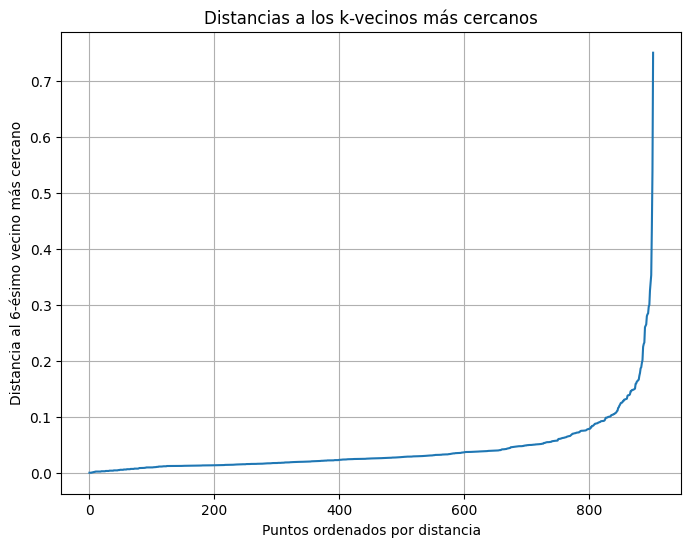

In [61]:
# Número de vecinos más cercanos (puedes probar con diferentes valores, como 4 o 5)
k = 6

# Crear el modelo de vecinos más cercanos
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X2_normal_cen)

# Calcular las distancias a los k-vecinos más cercanos
distances, indices = neighbors_fit.kneighbors(X2_normal_cen)

# Obtener la distancia al k-vecino más cercano (usamos la última columna que es la distancia al k-ésimo vecino)
distances = np.sort(distances[:, k-1], axis=0)

# Graficar las distancias
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title('Distancias a los k-vecinos más cercanos')
plt.xlabel('Puntos ordenados por distancia')
plt.ylabel(f'Distancia al {k}-ésimo vecino más cercano')
plt.grid(True)
plt.show()

In [62]:
dbcscan_alb = DBSCAN(eps=0.15, min_samples=8)
dbcscan_labels_alb = dbcscan_alb.fit_predict(X2_normal_alb)

dbcscan_cen = DBSCAN(eps=0.15, min_samples=8)
dbcscan_labels_cen = dbcscan_cen.fit_predict(X2_normal_cen)

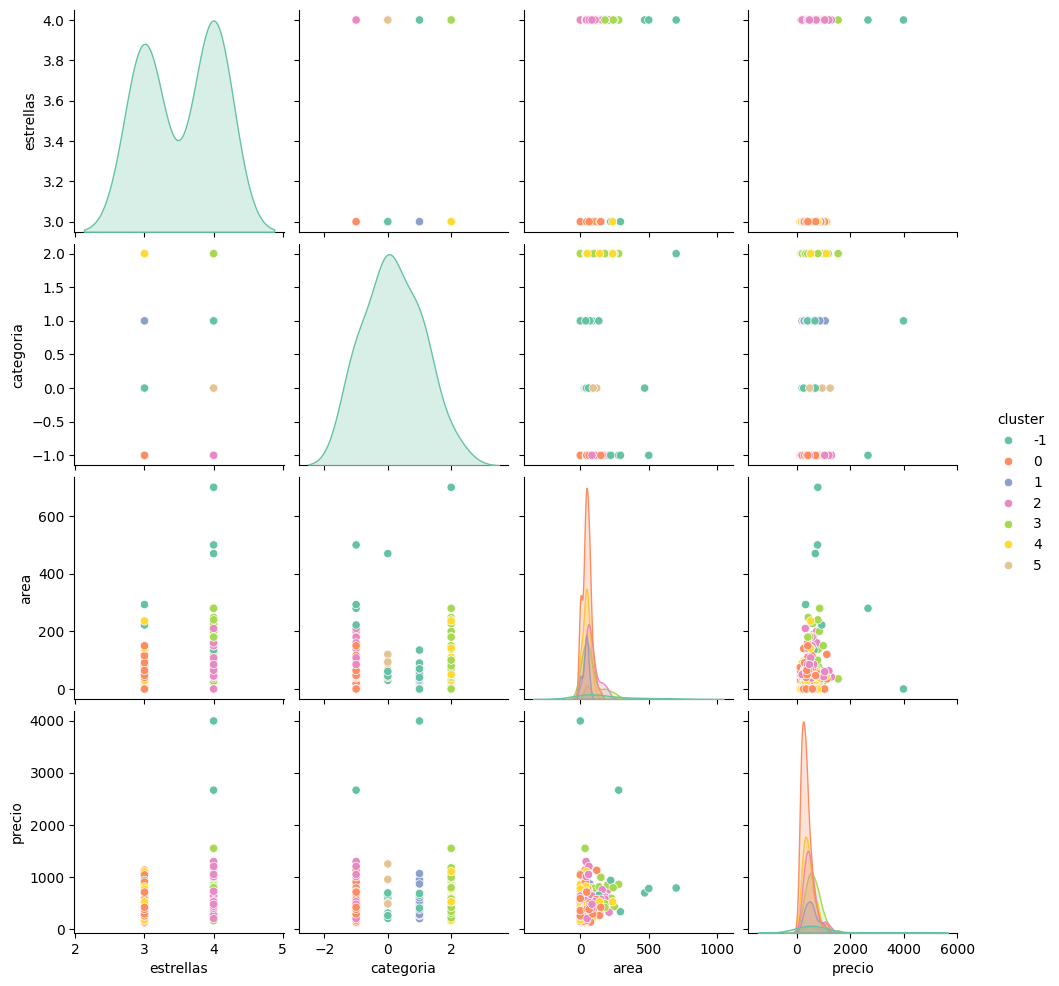

In [63]:
# Scatter matrix
clusters = pd.DataFrame(dbcscan_labels_alb, index=X2_normal_alb.index, columns=['cluster'])
datos3_cluster_alb['cluster'] = clusters['cluster']
sns.pairplot(datos3_cluster_alb, vars=['estrellas','categoria','area', 'precio'], hue="cluster", palette="Set2")
plt.show()

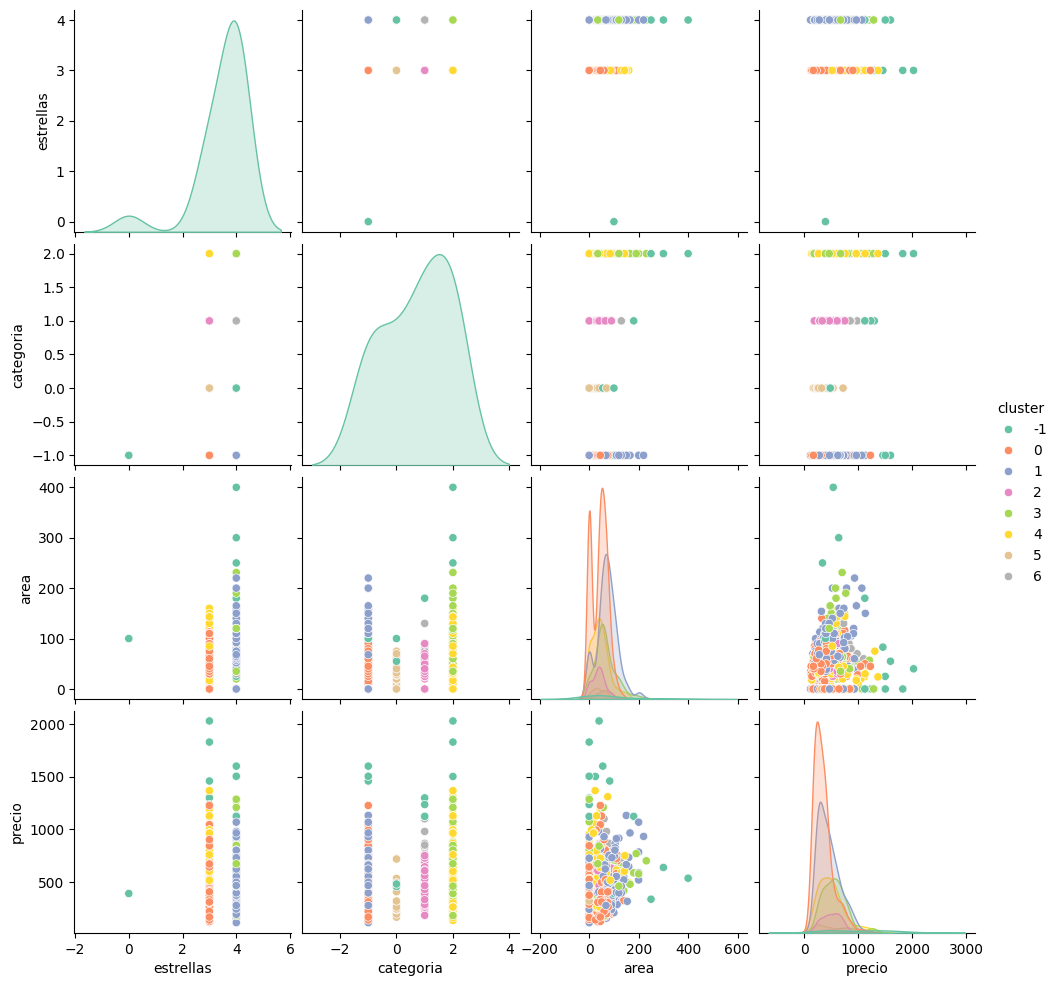

In [64]:
# Scatter matrix
clusters = pd.DataFrame(dbcscan_labels_cen, index=X2_normal_cen.index, columns=['cluster'])
datos3_cluster_cen['cluster'] = clusters['cluster']
sns.pairplot(datos3_cluster_cen, vars=['estrellas','categoria','area', 'precio'], hue="cluster", palette="Set2")
plt.show()

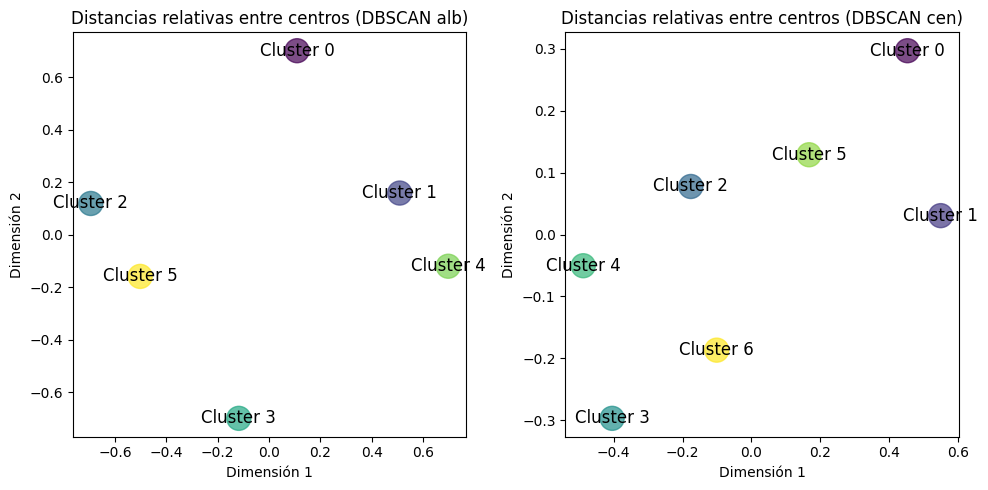

In [65]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

def calcular_centroides(X, labels):
    """
    Calcula los centroides para cada clúster basado en las etiquetas.
    """
    unique_labels = np.unique(labels[labels >= 0])  # Ignoramos ruido (-1)
    centroides = []
    for label in unique_labels:
        cluster_points = X[labels == label]
        centroid = cluster_points.mean(axis=0)
        centroides.append(centroid)
    return np.array(centroides), unique_labels

# Calcular centroides para DBSCAN alb y cen
centroides_alb, labels_alb = calcular_centroides(X2_normal_alb.to_numpy(), dbcscan_labels_alb)
centroides_cen, labels_cen = calcular_centroides(X2_normal_cen.to_numpy(), dbcscan_labels_cen)

# Calcular distancias entre centroides
distancias_alb = np.linalg.norm(centroides_alb[:, np.newaxis] - centroides_alb, axis=2)
distancias_cen = np.linalg.norm(centroides_cen[:, np.newaxis] - centroides_cen, axis=2)

# Reducir dimensionalidad usando MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=123456)

centroides_alb_2d = mds.fit_transform(distancias_alb)
centroides_cen_2d = mds.fit_transform(distancias_cen)

# Crear gráficos de burbujas
plt.figure(figsize=(10, 5))

# Gráfico para `dbcscan_alb`
plt.subplot(1, 2, 1)
plt.scatter(centroides_alb_2d[:, 0], centroides_alb_2d[:, 1], s=300, alpha=0.7, c=labels_alb, cmap="viridis")
for i, (x, y) in enumerate(centroides_alb_2d):
    plt.text(x, y, f'Cluster {i}', fontsize=12, ha='center', va='center')
plt.title("Distancias relativas entre centros (DBSCAN alb)")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")

# Gráfico para `dbcscan_cen`
plt.subplot(1, 2, 2)
plt.scatter(centroides_cen_2d[:, 0], centroides_cen_2d[:, 1], s=300, alpha=0.7, c=labels_cen, cmap="viridis")
for i, (x, y) in enumerate(centroides_cen_2d):
    plt.text(x, y, f'Cluster {i}', fontsize=12, ha='center', va='center')
plt.title("Distancias relativas entre centros (DBSCAN cen)")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")

plt.tight_layout()
plt.show()


## BIRCH

Calinski-Harabasz Index: 402.922, Silhouette: 0.607, tiempo ejecución: 0.015048742294311523


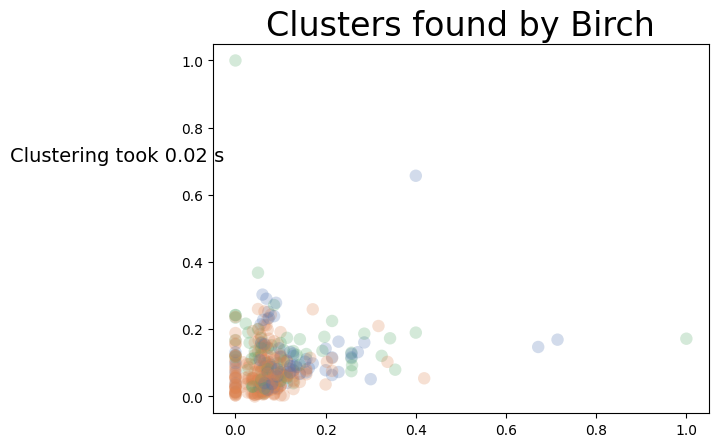

In [66]:
plot_clusters(X2_normal_alb, Birch, (), {'n_clusters': 3})

Calinski-Harabasz Index: 3545.145, Silhouette: 0.703, tiempo ejecución: 0.025699377059936523


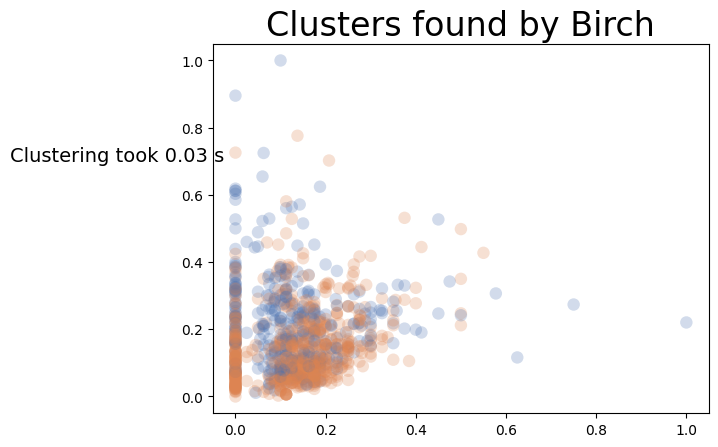

In [67]:
plot_clusters(X2_normal_cen, Birch, (), {'n_clusters': 2})

In [68]:
birch_alb = Birch(n_clusters=3)
birch_labels_alb = birch_alb.fit_predict(X2_normal_alb)

birch_cen = Birch(n_clusters=2)
birch_labels_cen = birch_cen.fit_predict(X2_normal_cen)

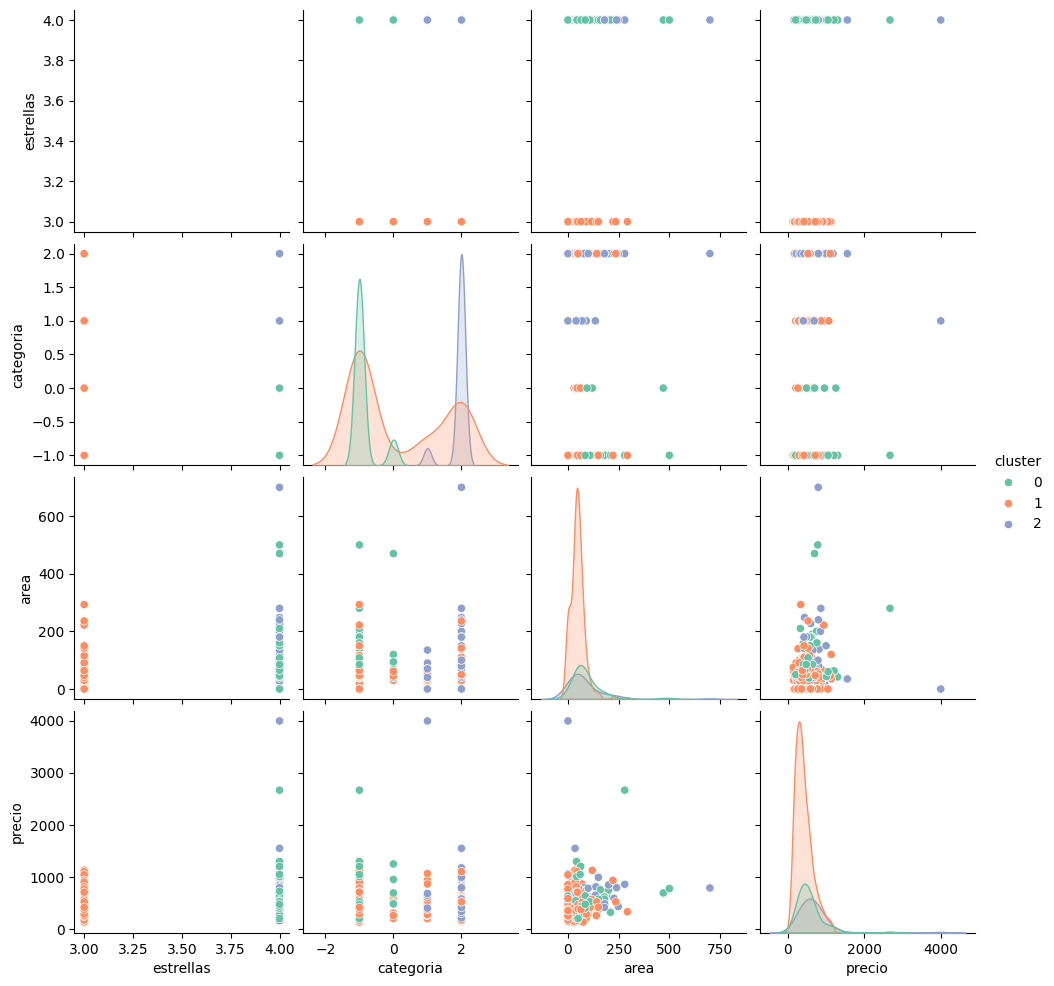

In [69]:
# Scatter matrix
clusters = pd.DataFrame(birch_labels_alb, index=X2_normal_alb.index, columns=['cluster'])
datos3_cluster_alb['cluster'] = clusters['cluster']
sns.pairplot(datos3_cluster_alb, vars=['estrellas','categoria','area', 'precio'], hue="cluster", palette="Set2")
plt.show()

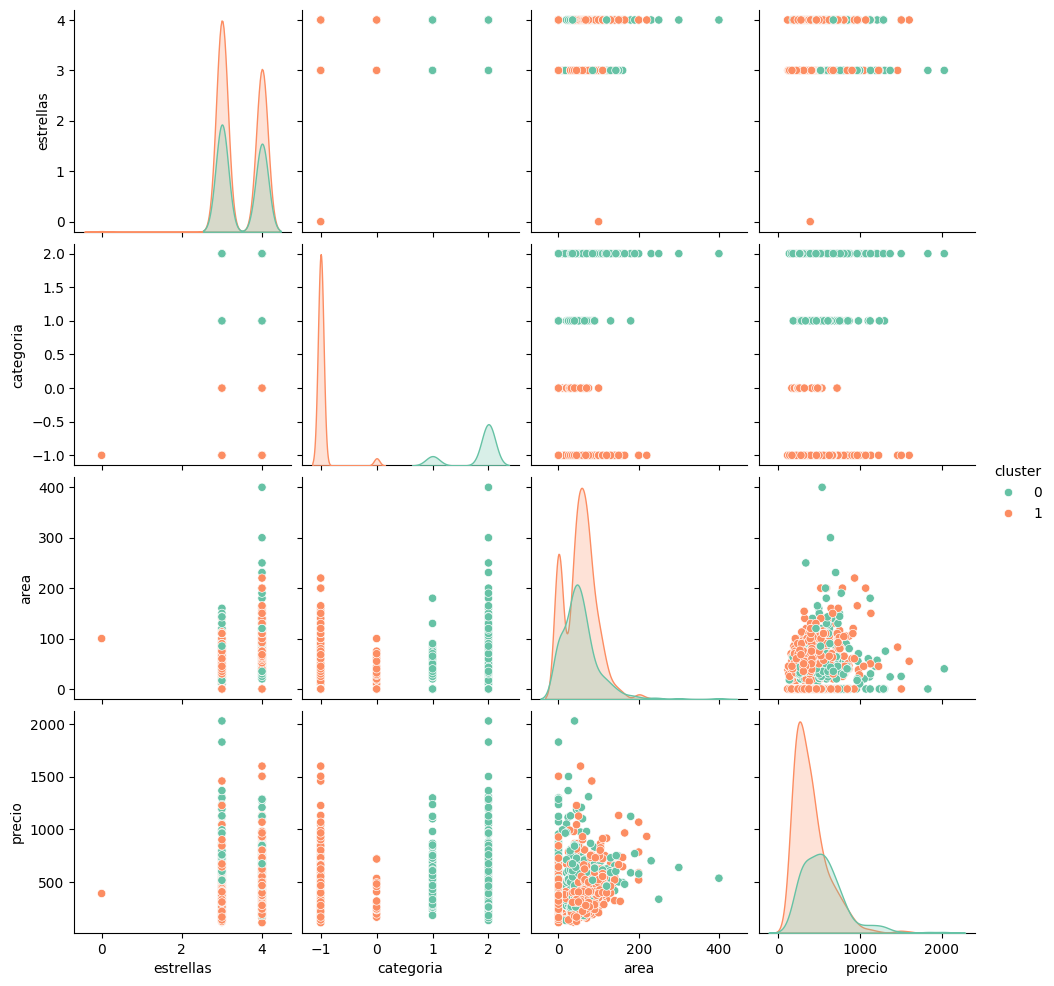

In [70]:
clusters = pd.DataFrame(birch_labels_cen, index=X2_normal_cen.index, columns=['cluster'])
datos3_cluster_cen['cluster'] = clusters['cluster']
sns.pairplot(datos3_cluster_cen, vars=['estrellas','categoria','area', 'precio'], hue="cluster", palette="Set2")
plt.show()

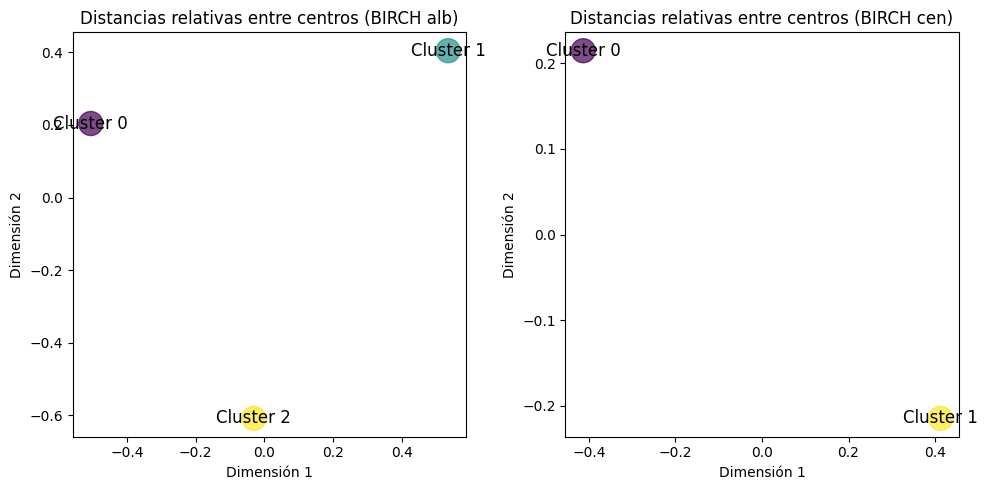

In [71]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Obtener los centroides del modelo BIRCH
def obtener_centroides_birch(model, X, labels):
    unique_labels = np.unique(labels)
    centroides = []
    for label in unique_labels:
        cluster_points = X[labels == label]
        centroid = cluster_points.mean(axis=0)
        centroides.append(centroid)
    return np.array(centroides), unique_labels

# Calcular centroides para BIRCH alb y cen
centroides_alb, labels_alb = obtener_centroides_birch(birch_alb, X2_normal_alb.to_numpy(), birch_labels_alb)
centroides_cen, labels_cen = obtener_centroides_birch(birch_cen, X2_normal_cen.to_numpy(), birch_labels_cen)

# Calcular distancias entre centroides
distancias_alb = np.linalg.norm(centroides_alb[:, np.newaxis] - centroides_alb, axis=2)
distancias_cen = np.linalg.norm(centroides_cen[:, np.newaxis] - centroides_cen, axis=2)

# Reducir dimensionalidad con MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=123456)

centroides_alb_2d = mds.fit_transform(distancias_alb)
centroides_cen_2d = mds.fit_transform(distancias_cen)

# Crear gráficos de burbujas
plt.figure(figsize=(10, 5))

# Gráfico para `birch_alb`
plt.subplot(1, 2, 1)
plt.scatter(centroides_alb_2d[:, 0], centroides_alb_2d[:, 1], s=300, alpha=0.7, c=labels_alb, cmap="viridis")
for i, (x, y) in enumerate(centroides_alb_2d):
    plt.text(x, y, f'Cluster {i}', fontsize=12, ha='center', va='center')
plt.title("Distancias relativas entre centros (BIRCH alb)")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")

# Gráfico para `birch_cen`
plt.subplot(1, 2, 2)
plt.scatter(centroides_cen_2d[:, 0], centroides_cen_2d[:, 1], s=300, alpha=0.7, c=labels_cen, cmap="viridis")
for i, (x, y) in enumerate(centroides_cen_2d):
    plt.text(x, y, f'Cluster {i}', fontsize=12, ha='center', va='center')
plt.title("Distancias relativas entre centros (BIRCH cen)")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")

plt.tight_layout()
plt.show()


## GMM

In [72]:
# Ejecutar GMM
gmm_alb = GaussianMixture(n_components=4, random_state=123456)
inicio = time.time()
gmm_labels_alb = gmm_alb.fit_predict(X2_normal_alb)
fin = time.time()

# Evaluar la calidad
calinski_harabasz_gmm = metrics.calinski_harabasz_score(X2_normal_alb, gmm_labels_alb)
silhouette_gmm = metrics.silhouette_score(X2_normal_alb, gmm_labels_alb)
print(f"GMM Calinski-Harabasz Index: {calinski_harabasz_gmm:.3f}, k-means Silhouette: {silhouette_gmm:.3f}, tiempo ejecución: {fin-inicio}")


GMM Calinski-Harabasz Index: 1849.339, k-means Silhouette: 0.793, tiempo ejecución: 0.026360034942626953


In [73]:
# Ejecutar GMM
gmm_cen = GaussianMixture(n_components=2, random_state=123456)
inicio = time.time()
gmm_labels_cen = gmm_cen.fit_predict(X2_normal_cen)
fin = time.time()

# Evaluar la calidad
calinski_harabasz_gmm = metrics.calinski_harabasz_score(X2_normal_cen, gmm_labels_cen)
silhouette_gmm = metrics.silhouette_score(X2_normal_cen, gmm_labels_cen)
print(f"GMM Calinski-Harabasz Index: {calinski_harabasz_gmm:.3f}, k-means Silhouette: {silhouette_gmm:.3f}, tiempo ejecución: {fin-inicio}")


GMM Calinski-Harabasz Index: 3136.001, k-means Silhouette: 0.681, tiempo ejecución: 0.024968624114990234


In [74]:
# encontrar numero optimo de clusters por puntuacionde silueta
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

n_clusters=np.arange(2, 20)
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2).fit(X2_normal_alb)
        labels=gmm.predict(X2_normal_alb)
        sil=metrics.silhouette_score(X2_normal_alb, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

Text(0, 0.5, 'Score')

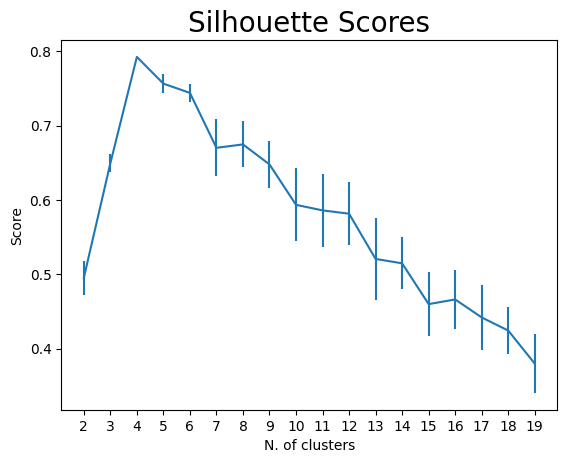

In [75]:
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

In [76]:
# encontrar numero optimo de clusters por puntuacionde silueta
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

n_clusters=np.arange(2, 20)
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2).fit(X2_normal_cen)
        labels=gmm.predict(X2_normal_cen)
        sil=metrics.silhouette_score(X2_normal_cen, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

Text(0, 0.5, 'Score')

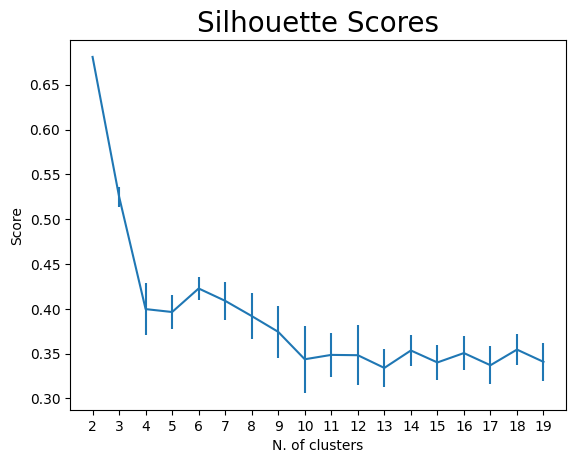

In [77]:
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

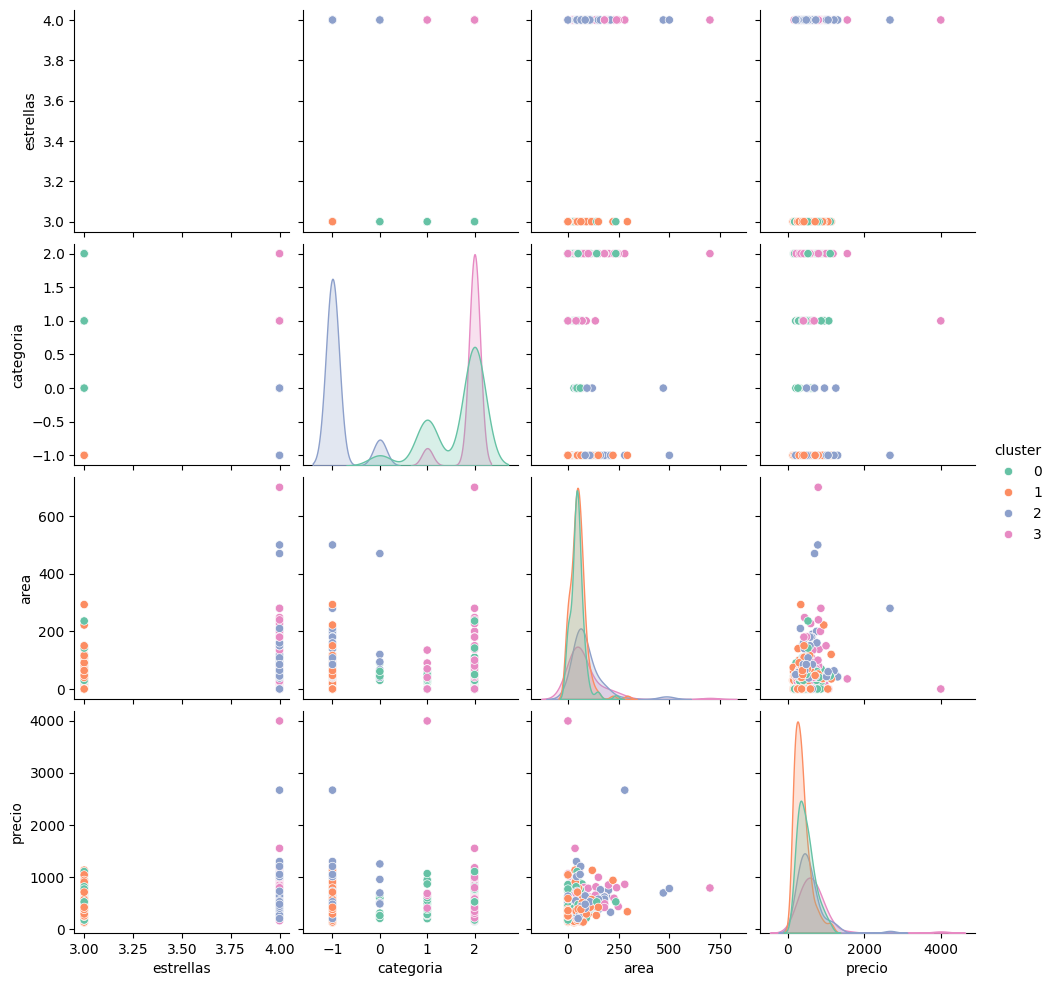

In [78]:
# Scatter matrix
clusters = pd.DataFrame(gmm_labels_alb, index=X2_normal_alb.index, columns=['cluster'])
datos3_cluster_alb['cluster'] = clusters['cluster']
sns.pairplot(datos3_cluster_alb, vars=['estrellas','categoria','area', 'precio'], hue="cluster", palette="Set2")
plt.show()

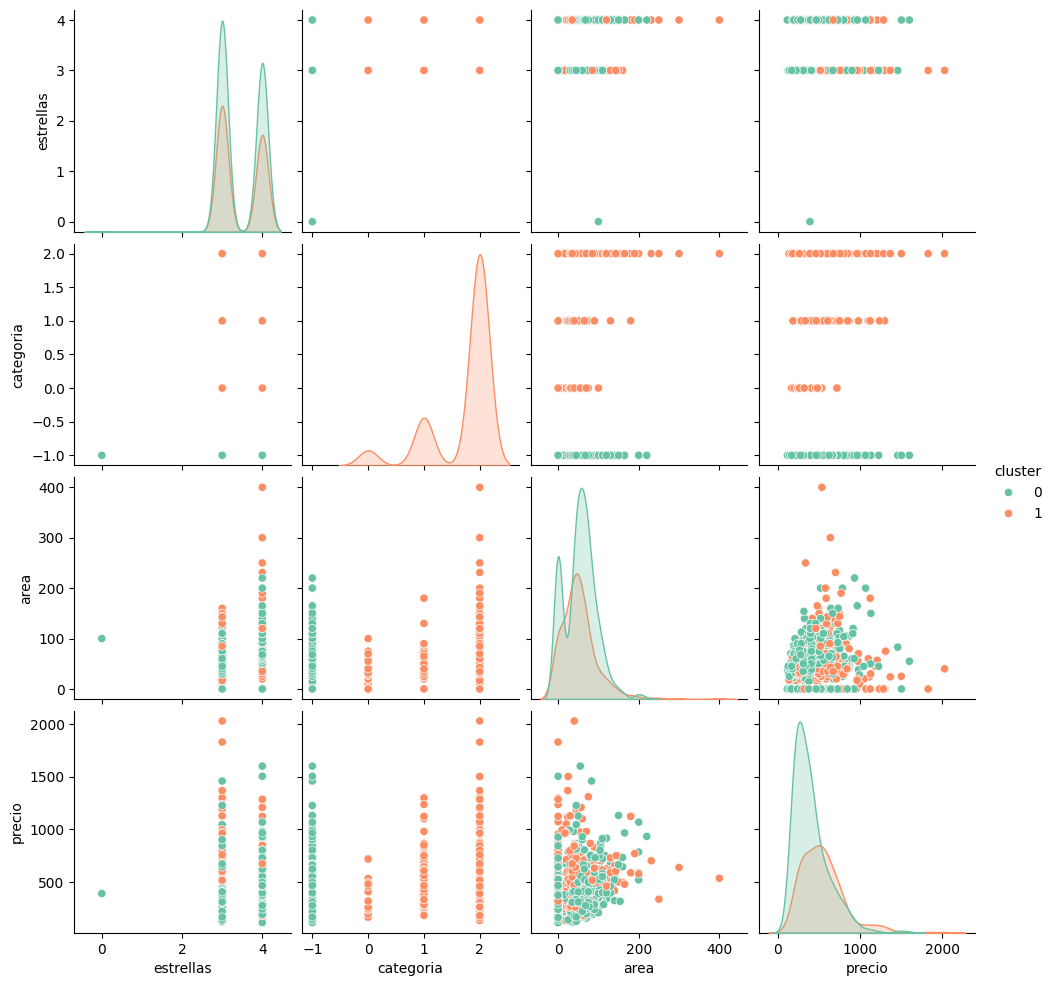

In [79]:
clusters = pd.DataFrame(gmm_labels_cen, index=X2_normal_cen.index, columns=['cluster'])
datos3_cluster_cen['cluster'] = clusters['cluster']
sns.pairplot(datos3_cluster_cen, vars=['estrellas','categoria','area', 'precio'], hue="cluster", palette="Set2")
plt.show()

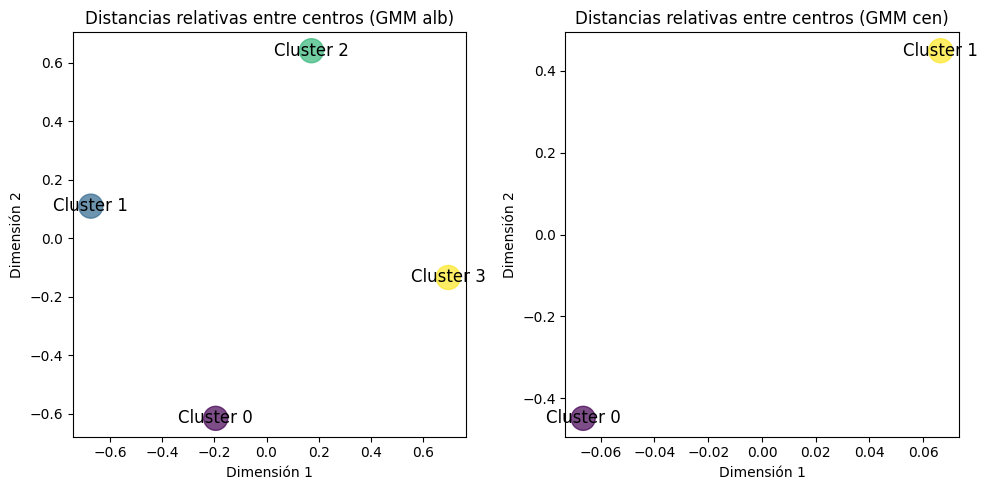

In [80]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Obtener los centros de los clústeres de GMM
gmm_centroids_alb = gmm_alb.means_
gmm_centroids_cen = gmm_cen.means_

# Calcular distancias entre centros
distancias_alb = np.linalg.norm(gmm_centroids_alb[:, np.newaxis] - gmm_centroids_alb, axis=2)
distancias_cen = np.linalg.norm(gmm_centroids_cen[:, np.newaxis] - gmm_centroids_cen, axis=2)

# Reducir dimensionalidad con MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=123456)

centroides_alb_2d = mds.fit_transform(distancias_alb)
centroides_cen_2d = mds.fit_transform(distancias_cen)

# Crear gráficos de burbujas
plt.figure(figsize=(10, 5))

# Gráfico para `gmm_alb`
plt.subplot(1, 2, 1)
plt.scatter(centroides_alb_2d[:, 0], centroides_alb_2d[:, 1], s=300, alpha=0.7, c=range(len(gmm_centroids_alb)), cmap="viridis")
for i, (x, y) in enumerate(centroides_alb_2d):
    plt.text(x, y, f'Cluster {i}', fontsize=12, ha='center', va='center')
plt.title("Distancias relativas entre centros (GMM alb)")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")

# Gráfico para `gmm_cen`
plt.subplot(1, 2, 2)
plt.scatter(centroides_cen_2d[:, 0], centroides_cen_2d[:, 1], s=300, alpha=0.7, c=range(len(gmm_centroids_cen)), cmap="viridis")
for i, (x, y) in enumerate(centroides_cen_2d):
    plt.text(x, y, f'Cluster {i}', fontsize=12, ha='center', va='center')
plt.title("Distancias relativas entre centros (GMM cen)")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")

plt.tight_layout()
plt.show()


# Caso de estudio 2

In [81]:
apartamentos_albaicin = datos[datos.Location.str.contains('Albaicín')]


# Selección de columnas y renombrado
columnas_renombradas = {"Price avg": "precio", "Rating": "valoracion",
                        "Ranking position avg": "ranking", "Total Beds": "dormitorios",
                        "Type":"tipo", "Quality":"estrellas","Guests":"huespedes",
                        "Distance":"distancia", "Number of views":"visitas",
                        "Review":"reseñas","Surface Area (m2)":'area',"Special":'categoria'}

datos2_cluster = apartamentos_albaicin.rename(columns=columnas_renombradas)
datos_kprot = apartamentos_albaicin.rename(columns=columnas_renombradas)

# Combinar conjuntos
# por ahora la que mas -> precio, estrellas (categoria)
usadas = ['estrellas','categoria','tipo']
# category to number in Special
datos_kprot = datos_kprot[usadas]
datos2_cluster['tipo'] = datos2_cluster['tipo'].astype('category')
print("Tipos de alojamiento nominal:",datos2_cluster['tipo'].unique())
datos2_cluster['tipo'] = datos2_cluster['tipo'].cat.codes
print("Tipos de alojamiento numérico:",datos2_cluster['tipo'].unique())
datos2_cluster['categoria'] = datos2_cluster['categoria'].astype('category')
print("Categorías de alojamiento nominal: ", datos2_cluster['categoria'].unique())
datos2_cluster['categoria'] = datos2_cluster['categoria'].cat.codes
print("Categorías de alojamiento numérico:",datos2_cluster['categoria'].unique())
datos2_cluster = datos2_cluster[usadas]

# Normalización
X2_normal = datos2_cluster.apply(norm_to_zero_one)

print(f"Alojamientos apartamentos: {len(X2_normal)}")


Tipos de alojamiento nominal: ['apartamento', NaN, 'hotel']
Categories (2, object): ['apartamento', 'hotel']
Tipos de alojamiento numérico: [ 0 -1  1]
Categorías de alojamiento nominal:  [NaN, 'plus', 'preferente', 'destacado']
Categories (3, object): ['destacado', 'plus', 'preferente']
Categorías de alojamiento numérico: [-1  1  2  0]
Alojamientos apartamentos: 444


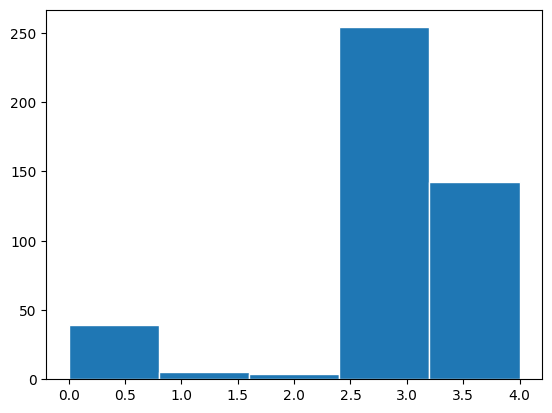

In [82]:
# histograma con el numero de alojamientos con cada número de estrellas (1 a 5)
unique, counts = np.unique(datos2_cluster['estrellas'], return_counts=True)
fig, ax = plt.subplots()
ax.hist(datos2_cluster['estrellas'],edgecolor = "white", bins=len(unique))
plt.show()

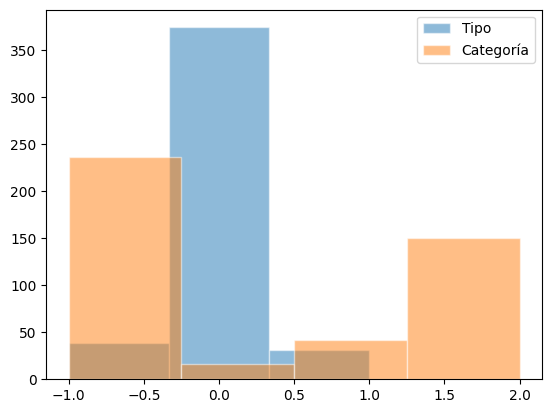

In [83]:
unique1, counts = np.unique(datos2_cluster['tipo'], return_counts=True)
unique2, counts = np.unique(datos2_cluster['categoria'], return_counts=True)
plt.hist(datos2_cluster['tipo'],alpha=0.5,edgecolor = "white", bins=len(unique1), label='Tipo')
plt.hist(datos2_cluster['categoria'],alpha=0.5,edgecolor = "white", bins=len(unique2), label='Categoría')
plt.legend(loc='upper right')
plt.show()

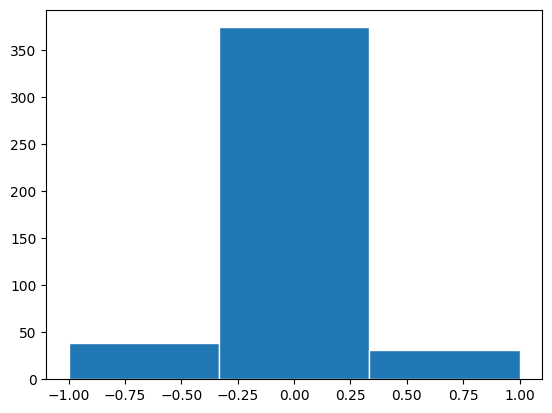

In [84]:
# histogramas para el numero de alojameintos con tipo y categoría
unique, counts = np.unique(datos2_cluster['tipo'], return_counts=True)
fig, ax = plt.subplots()
ax.hist(datos2_cluster['tipo'],edgecolor = "white", bins=len(unique))
plt.show()

In [85]:
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
def plot_clusters(data, algorithm, args, kwds,attributes=['estrellas','tipo']):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    metric_CH = metrics.calinski_harabasz_score(data, labels)
    metric_SC = metrics.silhouette_score(data, labels, metric='euclidean')
    print(f"Calinski-Harabasz Index: {metric_CH:.3f}, Silhouette: {metric_SC:.3f}, tiempo ejecución: {end_time-start_time}")

    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data[attributes[0]], data[attributes[1]], c=colors, **plot_kwds)
    frame = plt.gca()
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

## K-MEANS k=3

Calinski-Harabasz Index: 474.419, Silhouette: 0.628, tiempo ejecución: 0.0060863494873046875


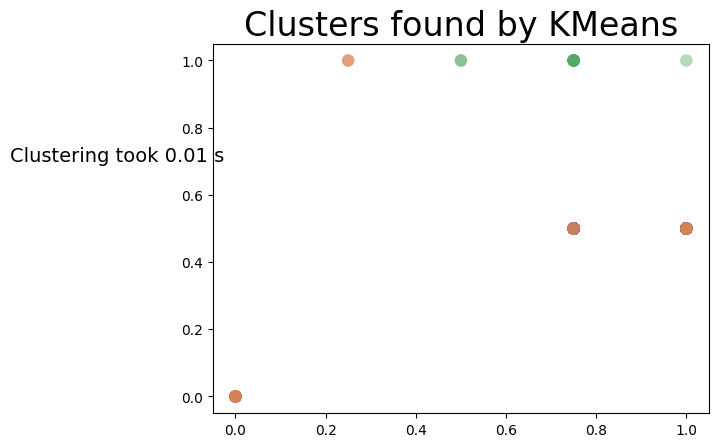

In [86]:
plot_clusters(X2_normal, KMeans, (), {'n_clusters':3})

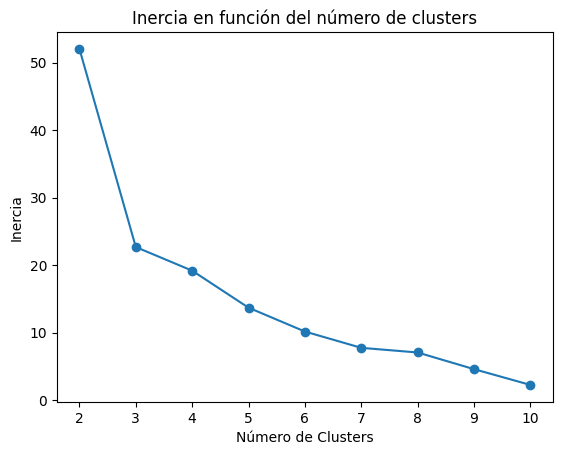

In [87]:
inercia = []
for k in range(2, 11):  # Probar con 2 a 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=123456)
    kmeans.fit(X2_normal)
    inercia.append(kmeans.inertia_)

# Graficar la inercia para diferentes valores de k
plt.plot(range(2, 11), inercia, marker='o')
plt.title("Inercia en función del número de clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Inercia")
plt.show()

In [88]:
k_means = KMeans(init='k-means++', n_clusters=3, n_init=5, random_state=123456)
kmeans_labels = k_means.fit_predict(X2_normal)

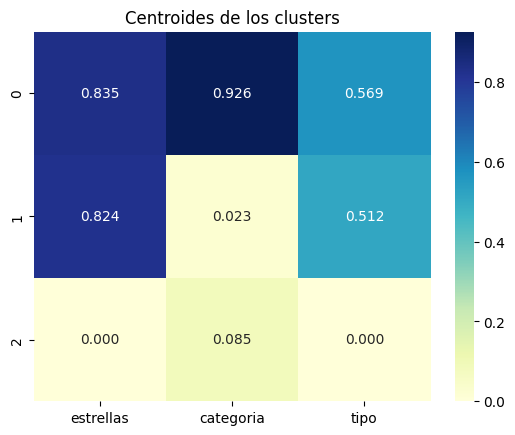

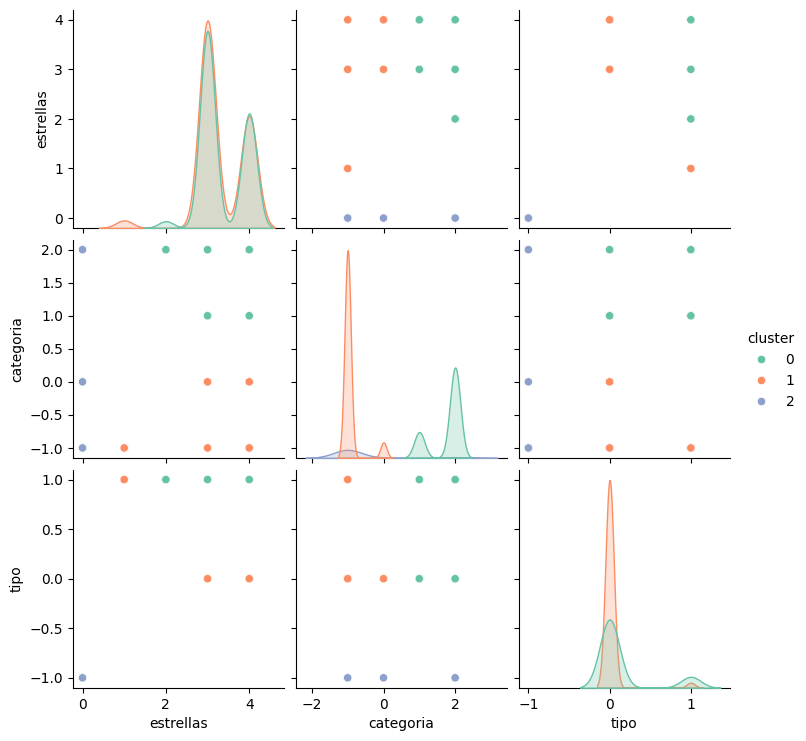

In [89]:
# Heatmap de centroides
centers = pd.DataFrame(k_means.cluster_centers_, columns=X2_normal.columns)
sns.heatmap(centers, cmap="YlGnBu", annot=True, fmt='.3f')
plt.title("Centroides de los clusters")
plt.show()

# Scatter matrix
clusters = pd.DataFrame(kmeans_labels, index=X2_normal.index, columns=['cluster'])
datos2_cluster['cluster'] = clusters['cluster']
sns.pairplot(datos2_cluster, vars=['estrellas','categoria','tipo'], hue="cluster", palette="Set2")
plt.show()

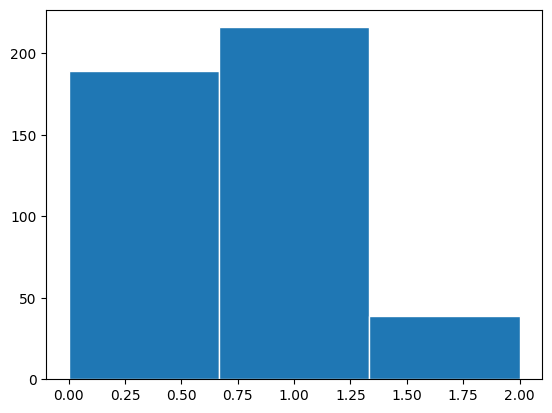

In [90]:
# histograma con cantidad de alojamientos en cada cluster
unique, counts = np.unique(kmeans_labels, return_counts=True)
fig, ax = plt.subplots()
ax.hist(kmeans_labels,edgecolor = "white", bins=len(unique))
plt.show()

In [91]:
# Distancias a los centroides
distances = kmeans.transform(X2_normal)

# Asignar la distancia mínima de cada punto al centroide más cercano
min_distances = distances.min(axis=1)

# Identificar puntos atípicos (por ejemplo, los que están más lejos de un umbral)
threshold = min_distances.mean() + 2 * min_distances.std()
outliers = datos2_cluster[min_distances > threshold]

print("Puntos atípicos:")
print(outliers)


Puntos atípicos:
      estrellas  categoria  tipo  cluster
211           3          0     0        1
241           4          0     0        1
326           4          0     0        1
327           4          0     0        1
328           4          0     0        1
364           3          0     0        1
365           3          0     0        1
366           3          0     0        1
407           2          2     1        0
408           2          2     1        0
409           2          2     1        0
655           0          0    -1        2
676           4          1     0        0
760           4          0     0        1
761           3          0     0        1
762           4          0     0        1
792           4          0     0        1
867           3          0     0        1
1009          4          0     0        1
1030          4          0     0        1
1368          2          2     1        0
1398          4          1     0        0
1457          4  

## K-means k=6

Calinski-Harabasz Index: 1286.789, Silhouette: 0.772, tiempo ejecución: 0.005434513092041016


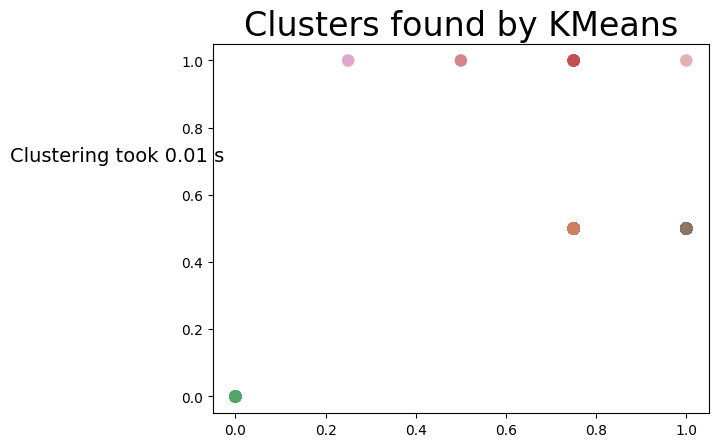

In [92]:
plot_clusters(X2_normal, KMeans, (), {'n_clusters':7})

In [93]:
k_means = KMeans(init='k-means++', n_clusters=7, n_init=5, random_state=123456)
kmeans_labels = k_means.fit_predict(X2_normal)

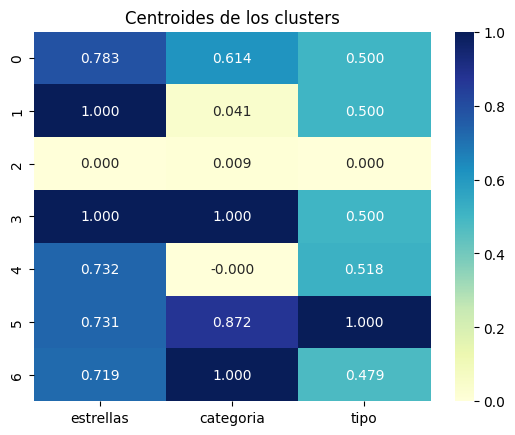

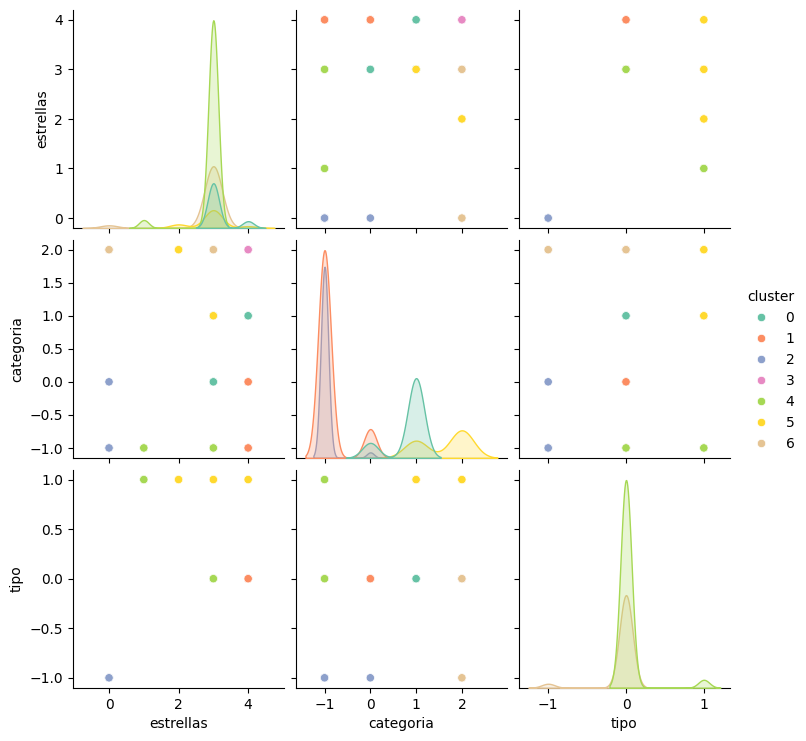

In [94]:
# Heatmap de centroides
centers = pd.DataFrame(k_means.cluster_centers_, columns=X2_normal.columns)
sns.heatmap(centers, cmap="YlGnBu", annot=True, fmt='.3f')
plt.title("Centroides de los clusters")
plt.show()

# Scatter matrix
clusters = pd.DataFrame(kmeans_labels, index=X2_normal.index, columns=['cluster'])
datos2_cluster['cluster'] = clusters['cluster']
sns.pairplot(datos2_cluster, vars=['estrellas','categoria','tipo'], hue="cluster", palette="Set2")
plt.show()

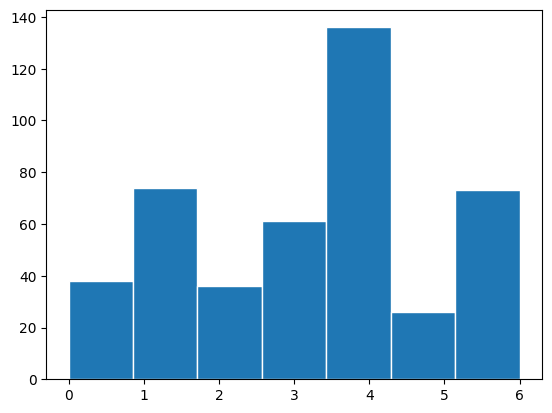

In [95]:
# histograma con cantidad de alojamientos en cada cluster
unique, counts = np.unique(kmeans_labels, return_counts=True)
fig, ax = plt.subplots()
ax.hist(kmeans_labels,edgecolor = "white", bins=len(unique))
plt.show()

## Agglomerative Clustering

Calinski-Harabasz Index: 956.672, Silhouette: 0.676, tiempo ejecución: 0.00897216796875


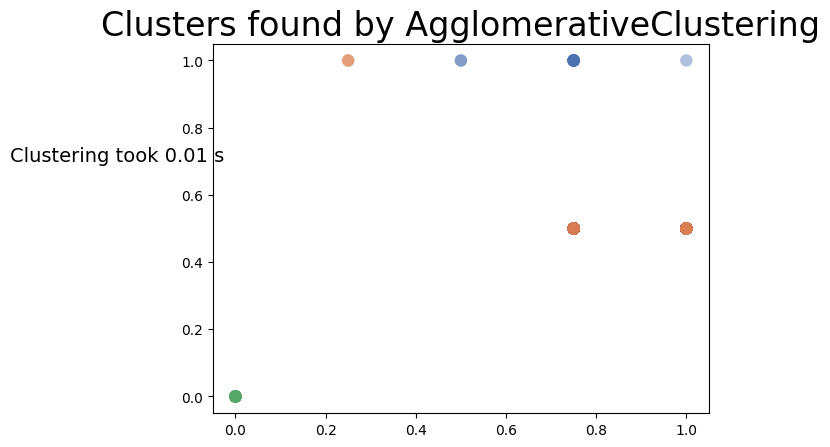

In [96]:
plot_clusters(X2_normal, AgglomerativeClustering, (), {'n_clusters': 4, 'linkage': 'ward'})

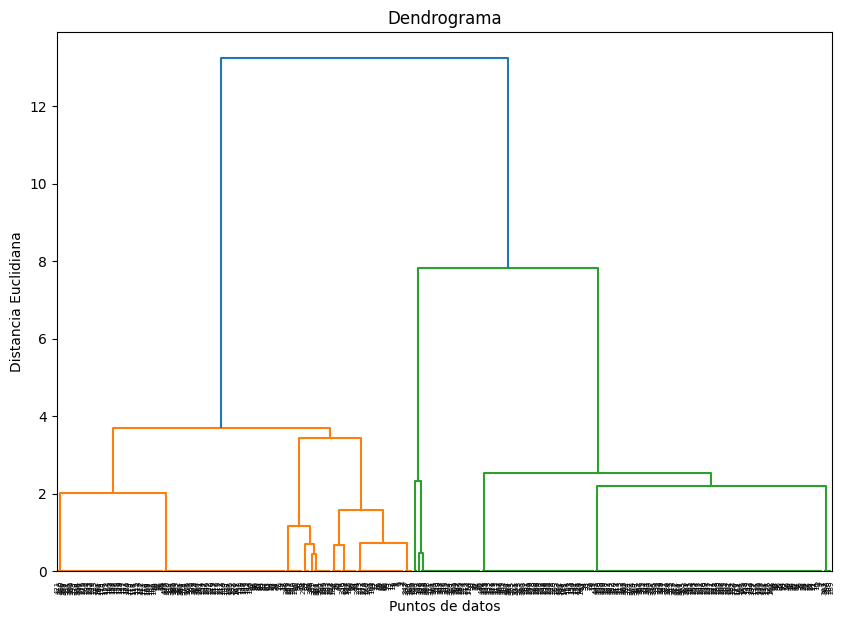

In [97]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(X2_normal, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Dendrograma')
plt.xlabel('Puntos de datos')
plt.ylabel('Distancia Euclidiana')
plt.show()


## k=2

Calinski-Harabasz Index: 684.049, Silhouette: 0.629, tiempo ejecución: 0.012120723724365234


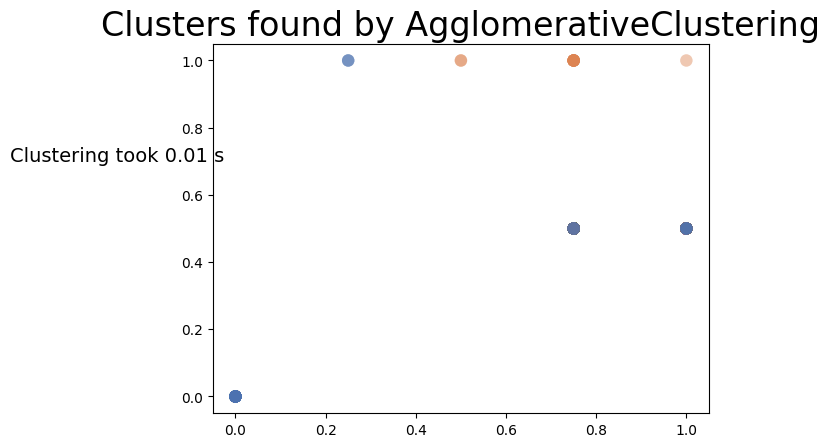

In [98]:
plot_clusters(X2_normal, AgglomerativeClustering, (), {'n_clusters': 2, 'linkage': 'ward'})

In [99]:
agglo = AgglomerativeClustering(n_clusters=2)
agglo_labels = agglo.fit_predict(X2_normal)

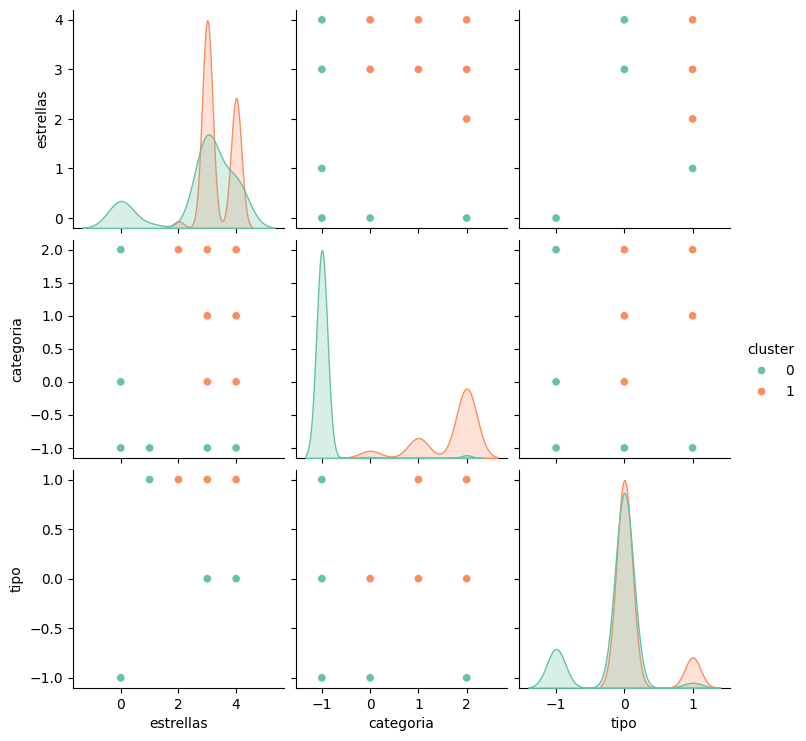

In [100]:
# Scatter matrix
clusters = pd.DataFrame(agglo_labels, index=X2_normal.index, columns=['cluster'])
datos2_cluster['cluster'] = clusters['cluster']
sns.pairplot(datos2_cluster, vars=['estrellas','categoria','tipo'], hue="cluster", palette="Set2")
plt.show()

## k=4

Calinski-Harabasz Index: 956.672, Silhouette: 0.676, tiempo ejecución: 0.010696887969970703


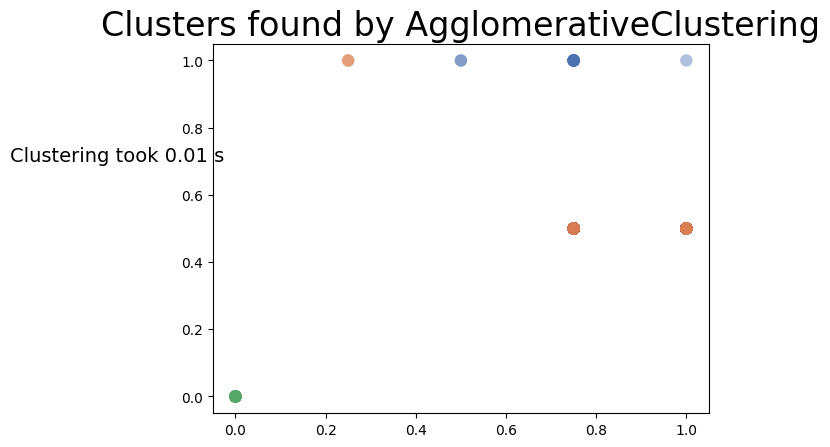

In [101]:
plot_clusters(X2_normal, AgglomerativeClustering, (), {'n_clusters': 4, 'linkage': 'ward'})

In [102]:
agglo = AgglomerativeClustering(n_clusters=4)
agglo_labels = agglo.fit_predict(X2_normal)

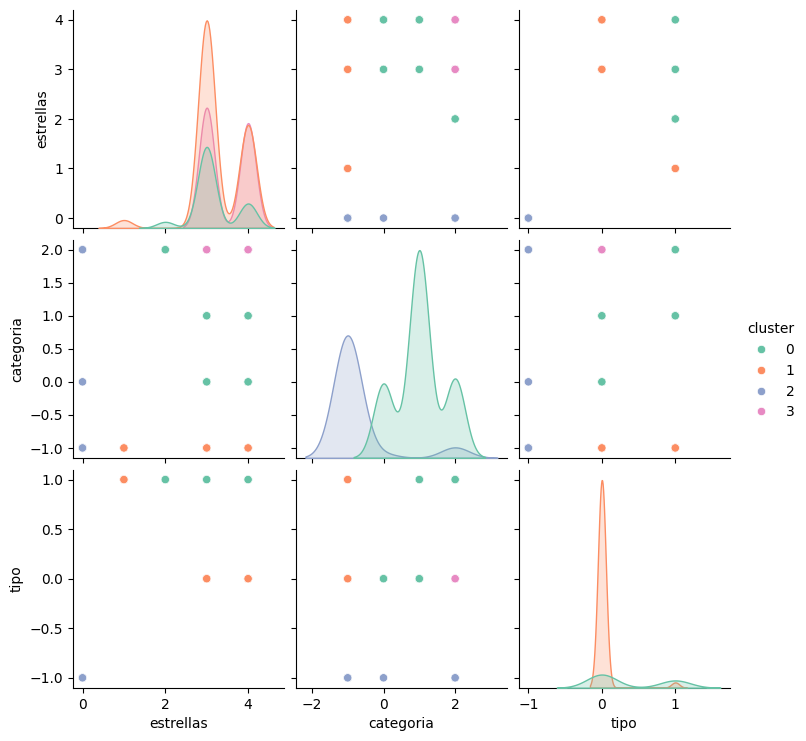

In [103]:
# Scatter matrix
clusters = pd.DataFrame(agglo_labels, index=X2_normal.index, columns=['cluster'])
datos2_cluster['cluster'] = clusters['cluster']
sns.pairplot(datos2_cluster, vars=['estrellas','categoria','tipo'], hue="cluster", palette="Set2")
plt.show()

## Spectral clusterin

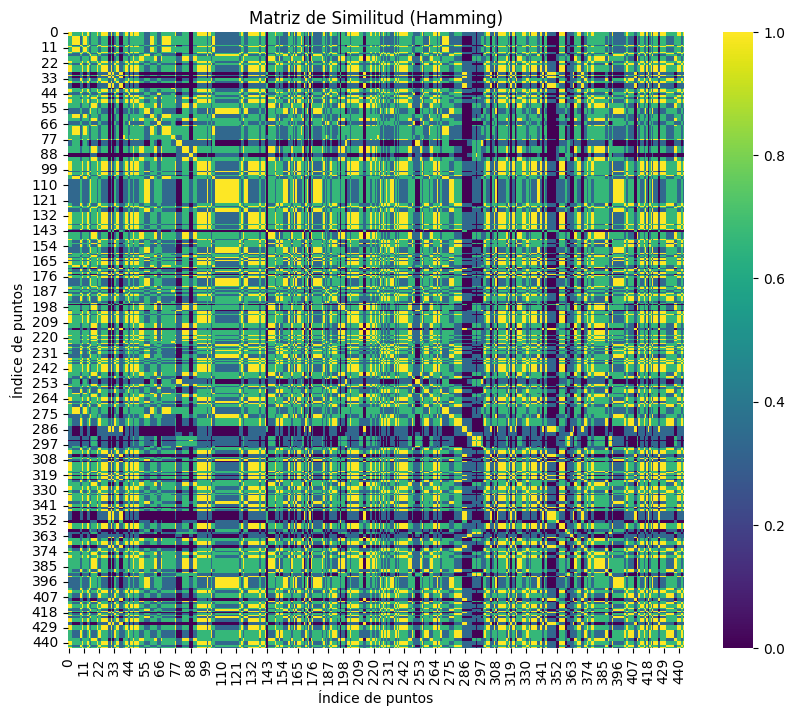

In [104]:
from sklearn.metrics.pairwise import pairwise_distances

# Crear matriz de similitud basada en distancia de Hamming
similarity_matrix = 1 - pairwise_distances(X2_normal, metric='hamming')  # Valores entre 0 y 1

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='viridis', square=True)
plt.title("Matriz de Similitud (Hamming)")
plt.xlabel("Índice de puntos")
plt.ylabel("Índice de puntos")
plt.show()


In [105]:
spectral = SpectralClustering(n_clusters=4, affinity='precomputed', random_state=42)
spectral_labels = spectral.fit_predict(similarity_matrix)

Calinski-Harabasz Index: 1037.656, Silhouette: 0.747, tiempo ejecución: 0.14391469955444336


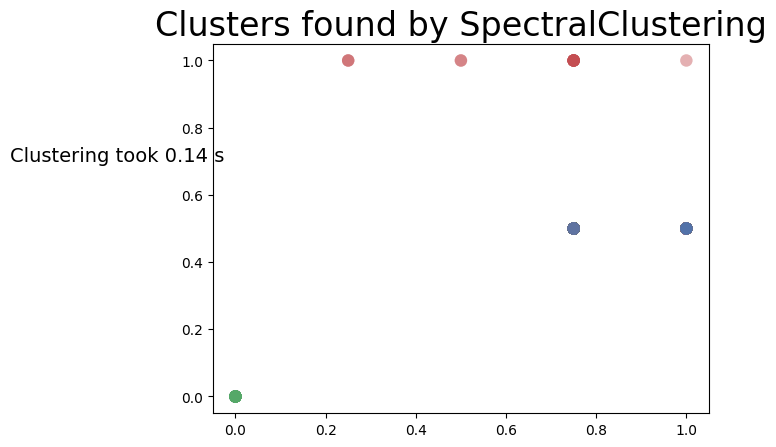

In [106]:
#llamar a plot_clusters
plot_clusters(X2_normal, SpectralClustering, (), {'n_clusters': 4, 'affinity': 'rbf', 'random_state': 42})

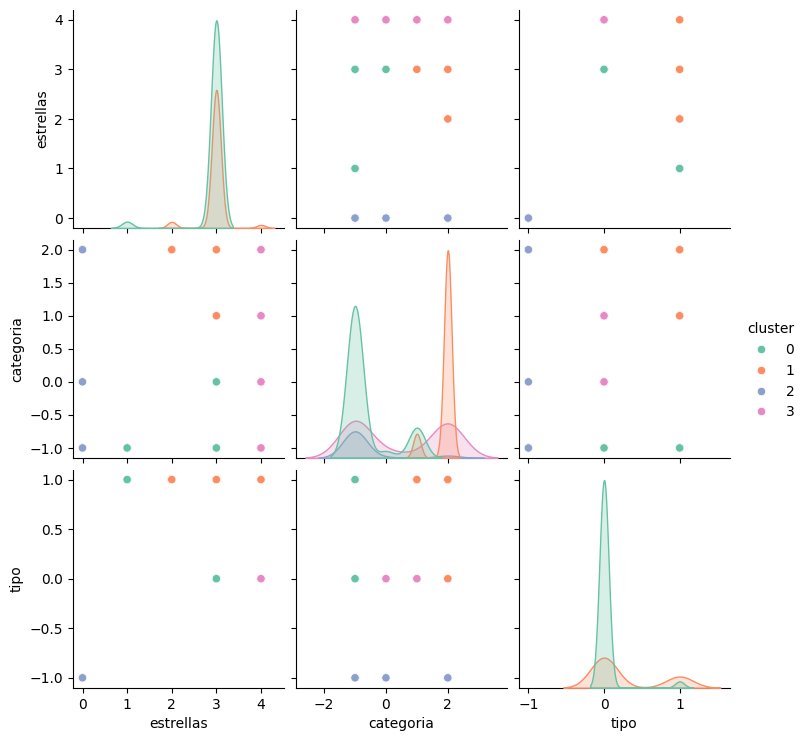

In [108]:
# Scatter matrix
clusters = pd.DataFrame(spectral_labels, index=X2_normal.index, columns=['cluster'])
datos2_cluster['cluster'] = clusters['cluster']
sns.pairplot(datos2_cluster, vars=['estrellas','categoria','tipo'], hue="cluster", palette="Set2")
plt.show()

## BIRCH

Calinski-Harabasz Index: 915.637, Silhouette: 0.760, tiempo ejecución: 0.039409637451171875


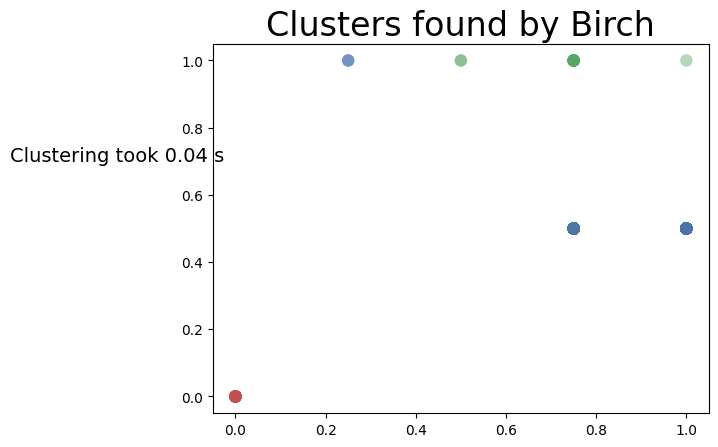

In [109]:
plot_clusters(X2_normal, Birch, (), {'n_clusters':4, 'threshold':0.15,'branching_factor':10})


In [110]:
# implementacion de birch
birch = Birch(n_clusters=4, threshold=0.15, branching_factor=10)
birch_labels = birch.fit_predict(X2_normal)

In [111]:
from itertools import product

# Rango de parámetros a evaluar
threshold_values = np.arange(0.05, 0.5, 0.05)  # Valores de threshold
branching_factors = [10, 20, 30, 50]         # Valores de branching_factor
n_clusters_values = [2, 3, 4, 5, 6]    # Valores de n_clusters

# Variables para almacenar los mejores resultados
best_score = -1
best_params = None

# Iterar sobre todas las combinaciones de parámetros
for threshold, branching_factor, n_clusters in product(threshold_values, branching_factors, n_clusters_values):
    # Crear modelo BIRCH
    birch_model = Birch(threshold=threshold, branching_factor=branching_factor, n_clusters=n_clusters)
    birch_model.fit(X2_normal)

    # Predecir etiquetas
    labels = birch_model.predict(X2_normal)

    # Evitar cálculos si solo hay un clúster
    if len(np.unique(labels)) <= 1:
        continue

    # Calcular la puntuación Silhouette
    score = metrics.silhouette_score(X2_normal, labels)

    # Guardar los mejores parámetros
    if score > best_score:
        best_score = score
        best_params = {
            "threshold": threshold,
            "branching_factor": branching_factor,
            "n_clusters": n_clusters,
        }

# Mostrar los mejores parámetros y el puntaje correspondiente
print("Mejores parámetros:")
print(f"Threshold: {best_params['threshold']}")
print(f"Branching Factor: {best_params['branching_factor']}")
print(f"N Clusters: {best_params['n_clusters']}")
print(f"Mejor Silhouette Score: {best_score:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (5) by BIRCH is less than (6). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (5) by BIRCH is less than (6). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (5) by BIRCH is less than (6). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (5) by BIRCH is less than (6). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (4) by BIRCH is less than (5). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Mejores parámetros:
Threshold: 0.15000000000000002
Branching Factor: 10
N Clusters: 5
Mejor Silhouette Score: 0.7635


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (3) by BIRCH is less than (4). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (3) by BIRCH is less than (5). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (3) by BIRCH is less than (6). Decrease the threshold.
  warnings.warn(


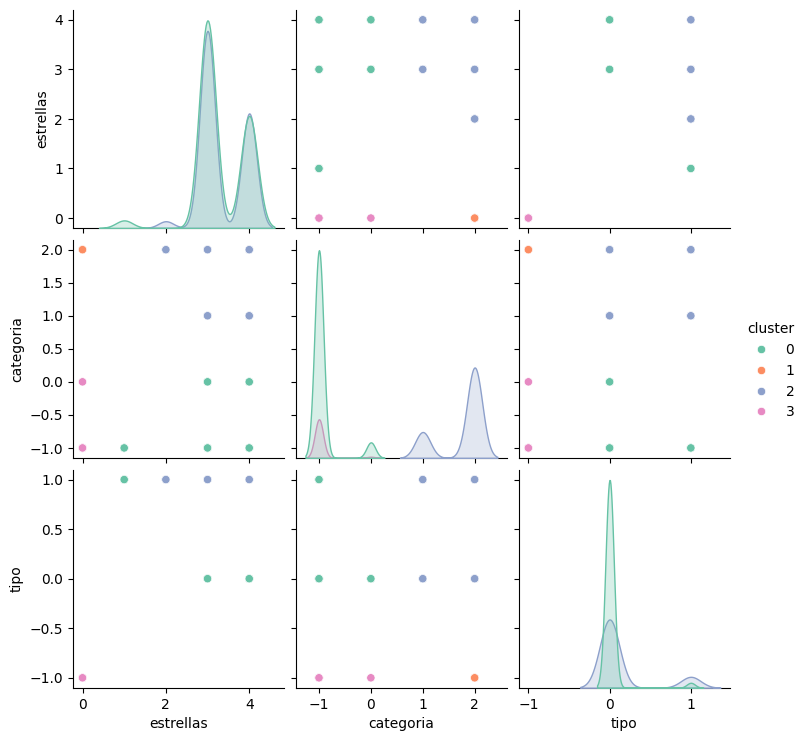

In [112]:
# Scatter matrix
clusters = pd.DataFrame(birch_labels, index=X2_normal.index, columns=['cluster'])
datos2_cluster['cluster'] = clusters['cluster']
sns.pairplot(datos2_cluster, vars=['estrellas','categoria','tipo'], hue="cluster", palette="Set2")
plt.show()

Cluster 0: 216 alojamientos
Cluster 1: 3 alojamientos
Cluster 2: 189 alojamientos
Cluster 3: 36 alojamientos


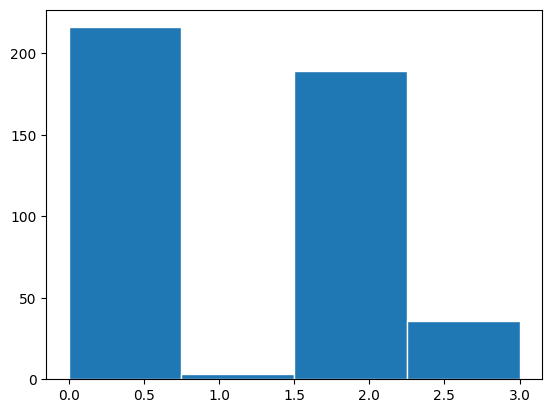

In [113]:
# alojamientos por cluster en histograma
unique, counts = np.unique(birch_labels, return_counts=True)
# añade la cantidad exacta
for i in range(len(unique)):
    print(f"Cluster {unique[i]}: {counts[i]} alojamientos")
fig, ax = plt.subplots()
ax.hist(birch_labels,edgecolor = "white", bins=len(unique))
plt.show()

## GMM

In [114]:
# encontrar numero optimo de clusters por puntuacionde silueta
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

n_clusters=np.arange(2, 25)
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2).fit(X2_normal)
        labels=gmm.predict(X2_normal)
        sil=metrics.silhouette_score(X2_normal, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/

Text(0, 0.5, 'Score')

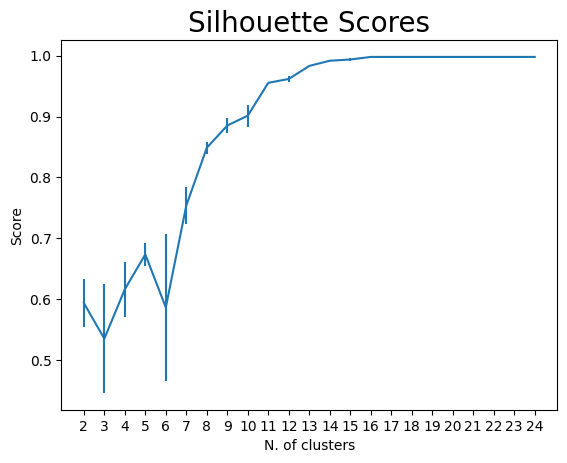

In [115]:
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

In [116]:
# Ejecutar GMM
gmm = GaussianMixture(n_components=4, random_state=123456)
inicio = time.time()
gmm_labels = gmm.fit_predict(X2_normal)
fin = time.time()

# Evaluar la calidad
calinski_harabasz_gmm = metrics.calinski_harabasz_score(X2_normal, gmm_labels)
silhouette_gmm = metrics.silhouette_score(X2_normal, gmm_labels)
print(f" Calinski-Harabasz Index: {calinski_harabasz_gmm:.3f}, Silhouette: {silhouette_gmm:.3f}, tiempo ejecución: {fin-inicio}")


 Calinski-Harabasz Index: 799.996, Silhouette: 0.599, tiempo ejecución: 0.024483442306518555


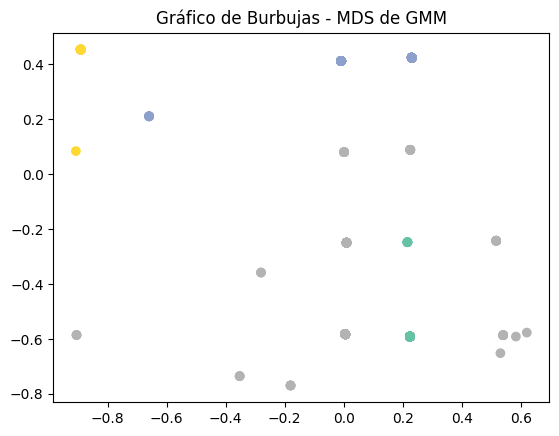

In [117]:
from sklearn.manifold import MDS

# Aplicar MDS para reducción de dimensionalidad
mds = MDS(n_components=2)
X_mds = mds.fit_transform(X2_normal)

# Gráfico de dispersión de MDS
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=gmm_labels, cmap="Set2")
plt.title("Gráfico de Burbujas - MDS de GMM")
plt.show()


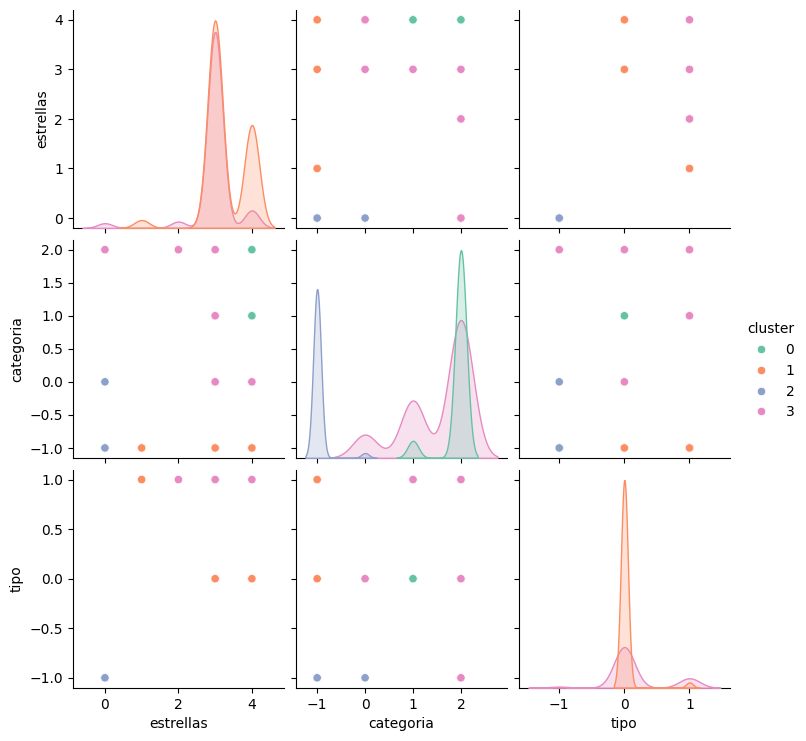

In [118]:
# Scatter matrix
clusters = pd.DataFrame(gmm_labels, index=X2_normal.index, columns=['cluster'])
datos2_cluster['cluster'] = clusters['cluster']
sns.pairplot(datos2_cluster, vars=['estrellas','categoria','tipo'], hue="cluster", palette="Set2")
plt.show()

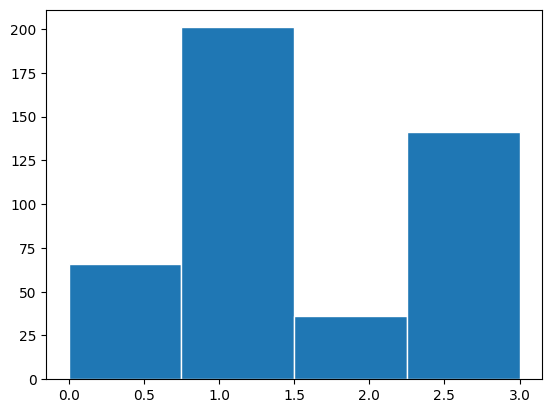

In [119]:
# cantidad de elementos en cada clsuter con histograma
unique, counts = np.unique(gmm_labels, return_counts=True)
fig, ax = plt.subplots()
ax.hist(gmm_labels,edgecolor = "white", bins=len(unique))
plt.show()

Calinski-Harabasz Index: 1026.813, Silhouette: 0.745, tiempo ejecución: 0.01618790626525879


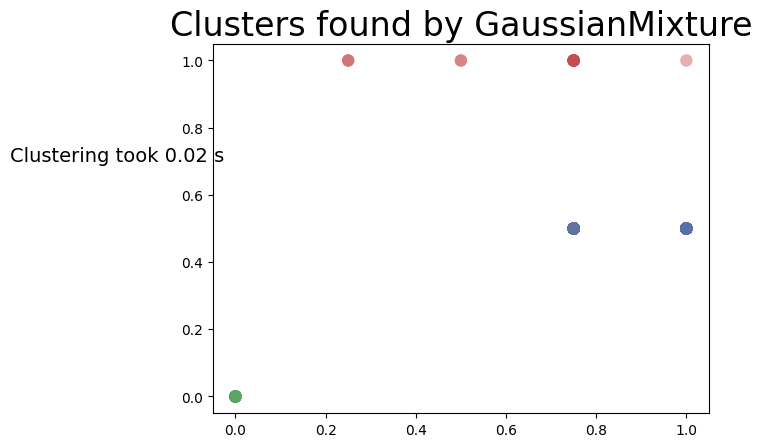

In [120]:
# implementation mixture models
from sklearn.mixture import GaussianMixture

plot_clusters(X2_normal, GaussianMixture, (), {'n_components': 4, 'random_state': 42})